In [ ]:
"""
Author: kiduk kang

Description: This notebook conducts hyperparameter tuning for patient wise classifier(RNN model)
"""
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import os
import optuna
from optuna.trial import TrialState
import logging
import sys

In [2]:
with open('/ceph/inestp02/stroke_classifier/data/patientwise/preprocess/patient_data_combine.pickle', 'rb') as f:
    patientwise_scans = pickle.load(f)


/ceph/kikang/miniconda3/envs/mtp/lib/python3.10/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_3418fe8f6'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/ceph/kikang/miniconda3/envs/mtp/lib/python3.10/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_add6771926'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/ceph/kikang/miniconda3/envs/mtp/lib/python3.10/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_35a32cfd9'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/ceph/kikang/miniconda3/envs/mtp/lib/python3.10/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: 'ID_a4124e

In [3]:
#extract sequence image data from the data and pad it to the max length
def extract_img(data, maxlen):
    x = [data[i]['img_preprocess'] for i in list(data.keys())]
    x = [np.concatenate((i, torch.zeros([maxlen-len(i)]+list(i[0].shape)))) for i in x]
    return x

def extract_features(images, model, device='cuda'):
    class Identity(nn.Module):
        def __init__(self):
            super(Identity, self).__init__()

        def forward(self, x):
            return x
        
    concatenated_features = []
    
    if model.__class__.__name__.find('ResNet') == 0:
        feature_extractor = nn.Sequential(*list(model.children())[:-1])
        classifier = nn.Sequential(*list(model.children())[-1])
        print('resnet')

    elif model.__class__.__name__.find('Vision') == 0:
        feature_extractor = model
        classifier = model.heads
        feature_extractor.heads = Identity()
        print('vision')

    feature_extractor.to(device)
    classifier.to(device)

    with torch.no_grad():
        for i, imgs in enumerate(images):
            temp = []
            for img in imgs:
                img = torch.Tensor(np.transpose(img, (2, 0, 1))).unsqueeze(0)
                img = img.to(device)
                features = feature_extractor(img).squeeze()
                features = features.to(device)
                output = classifier(features)

                concat_features = torch.cat((features,output)).unsqueeze(0)
                temp.append(concat_features)

            temp = torch.cat(temp)  # list of extracted features and logit 
            concatenated_features.append(temp)
    feature_list = torch.stack(concatenated_features)
    return feature_list  # list of features, number of patient *maxlen * n_class


class PatientwiseDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y


def extract_logit(images, model, device='cuda'):
    logit_list = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, imgs in enumerate(images):
            temp = []
            for img in imgs:
                img = torch.Tensor(np.transpose(img, (2, 0, 1))).unsqueeze(0)
                img = img.to(device)
                output = model(img)

                temp.append(output)

            temp = torch.cat(temp)  # list of probabilities in each patient
            logit_list.append(temp)
    logit_list = torch.stack(logit_list)
    return logit_list  # list of logits, number of patient *maxlen * n_class


In [94]:
model = models.vit_l_16(weights="DEFAULT")
in_features = model.heads.head.in_features
model.heads = nn.Sequential(
    nn.Linear(in_features=in_features, out_features=3, bias=True)
    )

model.load_state_dict(torch.load(
    'imagewise_models_state_dict/full_preprocess_14k/vit_l_16.ckpt'))
model.eval()


VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

In [52]:
resnet_model = models.resnet152(weights="DEFAULT")
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = 3)
    )
resnet_model.load_state_dict(torch.load('imagewise_models_state_dict/full_preprocess_14k/resnet152.ckpt'))
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
images = extract_img(patientwise_scans,80)

In [19]:
#checking feature shape for resnet model
device = 'cuda' if torch.cuda.is_available() else "cpu"

feature_extractor = nn.Sequential(*list(resnet_model.children())[:-1])
img = torch.Tensor(np.transpose(images[0][0],(2,0,1))).unsqueeze(0)
img = img.to(device)
#model.to(device)
#model(img)
feature_extractor.to(device)
feature_extractor(img).shape

torch.Size([1, 2048, 1, 1])

In [96]:
features = extract_features(images, model)

vision


In [98]:
features.shape

torch.Size([1194, 80, 1027])

In [99]:
X = features
y = torch.Tensor(list(i['patient_label'] for i in patientwise_scans.values()))

In [100]:
#os.mkdir('data/vit_features')
with open('data/vit_features/X.pickle', 'wb') as f:
    pickle.dump(X, f)
with open('data/vit_features/y.pickle', 'wb') as f:
    pickle.dump(y, f)

In [101]:

with open('data/vit_features/X.pickle', 'rb') as f:
    X = pickle.load(f)
with open('data/vit_features/y.pickle', 'rb') as f:
    y = pickle.load(f)


In [103]:
X.shape, y.shape

(torch.Size([1194, 80, 1027]), torch.Size([1194]))

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [105]:
X_train.shape, X_val.shape, X_test.shape

(torch.Size([859, 80, 1027]),
 torch.Size([96, 80, 1027]),
 torch.Size([239, 80, 1027]))

In [106]:
train_dataset = PatientwiseDataset(X_train, y_train)
val_dataset = PatientwiseDataset(X_val, y_val)
test_dataset = PatientwiseDataset(X_test, y_test)

In [107]:
train_loader = DataLoader(train_dataset, batch_size=4)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

In [109]:
# Define the BiGRU model
class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size,
                          num_layers, bidirectional=True, batch_first = True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0),
                         self.hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.gru(x, h0)
        # Use the last time step's output for classification
        out = self.fc(out[:, -1, :])
        return out


In [10]:
def objective(trial):
    #search space
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16, 32])
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
    hidden_size = trial.suggest_int('hidden_size',10,200)
    num_layer = trial.suggest_int('num_layer',1,5)

    #data    
    train_dataset = PatientwiseDataset(X_train, y_train)
    val_dataset = PatientwiseDataset(X_val, y_val)
    #test_dataset = PatientwiseDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    #test_loader = DataLoader(test_dataset, batch_size=4)
    # model

    device = "cuda" if torch.cuda.is_available() else "cpu"

    input_size = X_train.shape[-1]

    hidden_size = hidden_size
    num_layers = num_layer
    output_size = 3

    model = BiGRUModel(input_size, hidden_size, num_layers, output_size)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 500

    device = 'cuda' if torch.cuda.is_available() else "cpu"
    model.to(device)

    best_val_loss = np.inf
    patience = 20
    patience_check = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)

            # Compute loss
            loss = criterion(outputs, labels.type(torch.long))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_acc += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}'.format(
            epoch+1, num_epochs, train_loss, train_acc))

        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for i, (features, labels) in enumerate(val_loader):
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(features)
                loss = criterion(outputs, labels.type(torch.long))

                # Update loss and accuracy
                val_loss += loss.item() * features.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_acc += (predicted == labels).sum().item()

            # Compute average loss and accuracy for epoch
            val_loss /= len(val_loader.dataset)
            val_acc /= len(val_loader.dataset)
            print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(
                epoch+1, num_epochs, val_loss, val_acc))

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_check = 0
            else:
                patience_check += 1
            if patience_check >= patience:
                break
    
    return best_val_loss


In [11]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "gru_hyperparam" 
storage_name = "sqlite:///{}.db".format(study_name)
                
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-17 11:45:35,572] Using an existing study with name 'gru_hyperparam' instead of creating a new one.


Using an existing study with name 'gru_hyperparam' instead of creating a new one.
Using an existing study with name 'gru_hyperparam' instead of creating a new one.
Epoch [1/500], Train Loss: 1.0606, Train Accuracy: 0.4121
Epoch [1/500], Validation Loss: 0.8054, Validation Accuracy: 0.6250
Epoch [2/500], Train Loss: 0.6092, Train Accuracy: 0.6438
Epoch [2/500], Validation Loss: 0.7362, Validation Accuracy: 0.6458
Epoch [3/500], Train Loss: 0.4908, Train Accuracy: 0.6624
Epoch [3/500], Validation Loss: 0.5911, Validation Accuracy: 0.7188
Epoch [4/500], Train Loss: 0.4659, Train Accuracy: 0.6705
Epoch [4/500], Validation Loss: 0.4887, Validation Accuracy: 0.7604
Epoch [5/500], Train Loss: 0.4445, Train Accuracy: 0.7101
Epoch [5/500], Validation Loss: 0.6610, Validation Accuracy: 0.7292
Epoch [6/500], Train Loss: 0.3513, Train Accuracy: 0.8231
Epoch [6/500], Validation Loss: 0.6430, Validation Accuracy: 0.7604
Epoch [7/500], Train Loss: 0.2308, Train Accuracy: 0.8941
Epoch [7/500], Validat

[I 2023-07-17 11:46:46,923] Trial 56 finished with value: 0.48867562723656494 and parameters: {'batch_size': 4, 'lr': 0.00011407005423918412, 'hidden_size': 167, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.


Trial 56 finished with value: 0.48867562723656494 and parameters: {'batch_size': 4, 'lr': 0.00011407005423918412, 'hidden_size': 167, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.
Trial 56 finished with value: 0.48867562723656494 and parameters: {'batch_size': 4, 'lr': 0.00011407005423918412, 'hidden_size': 167, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1145, Train Accuracy: 0.3399
Epoch [1/500], Validation Loss: 1.0546, Validation Accuracy: 0.3125
Epoch [2/500], Train Loss: 0.6989, Train Accuracy: 0.6228
Epoch [2/500], Validation Loss: 0.7439, Validation Accuracy: 0.6458
Epoch [3/500], Train Loss: 0.5199, Train Accuracy: 0.6519
Epoch [3/500], Validation Loss: 0.5175, Validation Accuracy: 0.6875
Epoch [4/500], Train Loss: 0.4699, Train Accuracy: 0.7334
Epoch [4/500], Validation Loss: 0.4914, Validation Accuracy: 0.8021
Epoch [5/500], Train Loss: 0.4184, Train Accuracy: 0.7870
Epoch [5/500], Validation Loss: 0.42

[I 2023-07-17 11:47:13,717] Trial 57 finished with value: 0.4159078784286976 and parameters: {'batch_size': 8, 'lr': 0.00016498074683403093, 'hidden_size': 193, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.


Trial 57 finished with value: 0.4159078784286976 and parameters: {'batch_size': 8, 'lr': 0.00016498074683403093, 'hidden_size': 193, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Trial 57 finished with value: 0.4159078784286976 and parameters: {'batch_size': 8, 'lr': 0.00016498074683403093, 'hidden_size': 193, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1021, Train Accuracy: 0.3667
Epoch [1/500], Validation Loss: 1.0617, Validation Accuracy: 0.4688
Epoch [2/500], Train Loss: 0.8463, Train Accuracy: 0.6042
Epoch [2/500], Validation Loss: 0.7137, Validation Accuracy: 0.5417
Epoch [3/500], Train Loss: 0.5472, Train Accuracy: 0.6764
Epoch [3/500], Validation Loss: 0.7002, Validation Accuracy: 0.5312
Epoch [4/500], Train Loss: 0.4790, Train Accuracy: 0.7090
Epoch [4/500], Validation Loss: 0.5048, Validation Accuracy: 0.6042
Epoch [5/500], Train Loss: 0.4553, Train Accuracy: 0.7462
Epoch [5/500], Validation Loss: 0.4794

[I 2023-07-17 11:47:27,617] Trial 58 finished with value: 0.3748666133421163 and parameters: {'batch_size': 4, 'lr': 9.160220782823492e-05, 'hidden_size': 126, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.


Epoch [28/500], Train Loss: 0.0153, Train Accuracy: 0.9977
Epoch [28/500], Validation Loss: 0.8936, Validation Accuracy: 0.7917
Trial 58 finished with value: 0.3748666133421163 and parameters: {'batch_size': 4, 'lr': 9.160220782823492e-05, 'hidden_size': 126, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Trial 58 finished with value: 0.3748666133421163 and parameters: {'batch_size': 4, 'lr': 9.160220782823492e-05, 'hidden_size': 126, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1031, Train Accuracy: 0.3295
Epoch [1/500], Validation Loss: 1.1101, Validation Accuracy: 0.3021
Epoch [2/500], Train Loss: 1.1008, Train Accuracy: 0.3190
Epoch [2/500], Validation Loss: 1.1089, Validation Accuracy: 0.3021
Epoch [3/500], Train Loss: 1.1007, Train Accuracy: 0.3236
Epoch [3/500], Validation Loss: 1.1084, Validation Accuracy: 0.3021
Epoch [4/500], Train Loss: 1.0974, Train Accuracy: 0.3609
Epoch [4/500], Validation Loss: 1.0976

[I 2023-07-17 11:47:33,597] Trial 59 finished with value: 0.4169798518220584 and parameters: {'batch_size': 16, 'lr': 5.0278911704911e-05, 'hidden_size': 107, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.


Trial 59 finished with value: 0.4169798518220584 and parameters: {'batch_size': 16, 'lr': 5.0278911704911e-05, 'hidden_size': 107, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Trial 59 finished with value: 0.4169798518220584 and parameters: {'batch_size': 16, 'lr': 5.0278911704911e-05, 'hidden_size': 107, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1063, Train Accuracy: 0.3341
Epoch [1/500], Validation Loss: 1.0750, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9267, Train Accuracy: 0.5483
Epoch [2/500], Validation Loss: 0.7712, Validation Accuracy: 0.5104
Epoch [3/500], Train Loss: 0.6031, Train Accuracy: 0.6554
Epoch [3/500], Validation Loss: 0.6320, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.4958, Train Accuracy: 0.7206
Epoch [4/500], Validation Loss: 0.7046, Validation Accuracy: 0.6667
Epoch [5/500], Train Loss: 0.4441, Train Accuracy: 0.7846
Epoch [5/500], Validation Loss: 0.5301, Va

[I 2023-07-17 11:47:46,984] Trial 60 finished with value: 0.4325940213166177 and parameters: {'batch_size': 4, 'lr': 9.792572550982752e-05, 'hidden_size': 117, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.


Epoch [27/500], Train Loss: 0.0110, Train Accuracy: 0.9988
Epoch [27/500], Validation Loss: 0.8728, Validation Accuracy: 0.7604
Trial 60 finished with value: 0.4325940213166177 and parameters: {'batch_size': 4, 'lr': 9.792572550982752e-05, 'hidden_size': 117, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Trial 60 finished with value: 0.4325940213166177 and parameters: {'batch_size': 4, 'lr': 9.792572550982752e-05, 'hidden_size': 117, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 0.9874, Train Accuracy: 0.4529
Epoch [1/500], Validation Loss: 0.7768, Validation Accuracy: 0.4792
Epoch [2/500], Train Loss: 0.5806, Train Accuracy: 0.6426
Epoch [2/500], Validation Loss: 0.6590, Validation Accuracy: 0.5417
Epoch [3/500], Train Loss: 0.4838, Train Accuracy: 0.6682
Epoch [3/500], Validation Loss: 0.5272, Validation Accuracy: 0.5833
Epoch [4/500], Train Loss: 0.4652, Train Accuracy: 0.6845
Epoch [4/500], Validation Loss: 0.8068

[I 2023-07-17 11:47:59,347] Trial 61 finished with value: 0.4445067915755014 and parameters: {'batch_size': 4, 'lr': 0.00033282756468990855, 'hidden_size': 78, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.


Epoch [26/500], Train Loss: 0.0008, Train Accuracy: 1.0000
Epoch [26/500], Validation Loss: 1.2616, Validation Accuracy: 0.7500
Trial 61 finished with value: 0.4445067915755014 and parameters: {'batch_size': 4, 'lr': 0.00033282756468990855, 'hidden_size': 78, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Trial 61 finished with value: 0.4445067915755014 and parameters: {'batch_size': 4, 'lr': 0.00033282756468990855, 'hidden_size': 78, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 0.9869, Train Accuracy: 0.4366
Epoch [1/500], Validation Loss: 0.7509, Validation Accuracy: 0.7083
Epoch [2/500], Train Loss: 0.5552, Train Accuracy: 0.6694
Epoch [2/500], Validation Loss: 0.6414, Validation Accuracy: 0.7083
Epoch [3/500], Train Loss: 0.4072, Train Accuracy: 0.8102
Epoch [3/500], Validation Loss: 0.4453, Validation Accuracy: 0.7812
Epoch [4/500], Train Loss: 0.2698, Train Accuracy: 0.8941
Epoch [4/500], Validation Loss: 0.7568

[I 2023-07-17 11:48:17,411] Trial 62 finished with value: 0.44525179111709196 and parameters: {'batch_size': 4, 'lr': 0.00027248761291401584, 'hidden_size': 131, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.


Epoch [23/500], Train Loss: 0.0006, Train Accuracy: 1.0000
Epoch [23/500], Validation Loss: 1.2420, Validation Accuracy: 0.7917
Trial 62 finished with value: 0.44525179111709196 and parameters: {'batch_size': 4, 'lr': 0.00027248761291401584, 'hidden_size': 131, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Trial 62 finished with value: 0.44525179111709196 and parameters: {'batch_size': 4, 'lr': 0.00027248761291401584, 'hidden_size': 131, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.0842, Train Accuracy: 0.3842
Epoch [1/500], Validation Loss: 0.8694, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6483, Train Accuracy: 0.6286
Epoch [2/500], Validation Loss: 0.7312, Validation Accuracy: 0.7292
Epoch [3/500], Train Loss: 0.4804, Train Accuracy: 0.6903
Epoch [3/500], Validation Loss: 0.5143, Validation Accuracy: 0.7708
Epoch [4/500], Train Loss: 0.4252, Train Accuracy: 0.7730
Epoch [4/500], Validation Loss: 0.

[I 2023-07-17 11:48:31,357] Trial 63 finished with value: 0.4434935888275504 and parameters: {'batch_size': 4, 'lr': 0.0001760677864419152, 'hidden_size': 99, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.


Epoch [24/500], Train Loss: 0.0004, Train Accuracy: 1.0000
Epoch [24/500], Validation Loss: 1.2553, Validation Accuracy: 0.7917
Trial 63 finished with value: 0.4434935888275504 and parameters: {'batch_size': 4, 'lr': 0.0001760677864419152, 'hidden_size': 99, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Trial 63 finished with value: 0.4434935888275504 and parameters: {'batch_size': 4, 'lr': 0.0001760677864419152, 'hidden_size': 99, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1004, Train Accuracy: 0.3492
Epoch [1/500], Validation Loss: 1.0576, Validation Accuracy: 0.4479
Epoch [2/500], Train Loss: 0.7484, Train Accuracy: 0.5960
Epoch [2/500], Validation Loss: 0.7064, Validation Accuracy: 0.6146
Epoch [3/500], Train Loss: 0.5434, Train Accuracy: 0.6647
Epoch [3/500], Validation Loss: 0.6331, Validation Accuracy: 0.5625
Epoch [4/500], Train Loss: 0.4823, Train Accuracy: 0.6694
Epoch [4/500], Validation Loss: 0.6242, 

[I 2023-07-17 11:48:54,675] Trial 64 finished with value: 0.498057344617943 and parameters: {'batch_size': 4, 'lr': 7.354190643336243e-05, 'hidden_size': 91, 'num_layer': 5}. Best is trial 26 with value: 0.36872100542920333.


Epoch [29/500], Train Loss: 0.0027, Train Accuracy: 1.0000
Epoch [29/500], Validation Loss: 1.2489, Validation Accuracy: 0.7604
Trial 64 finished with value: 0.498057344617943 and parameters: {'batch_size': 4, 'lr': 7.354190643336243e-05, 'hidden_size': 91, 'num_layer': 5}. Best is trial 26 with value: 0.36872100542920333.
Trial 64 finished with value: 0.498057344617943 and parameters: {'batch_size': 4, 'lr': 7.354190643336243e-05, 'hidden_size': 91, 'num_layer': 5}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.0750, Train Accuracy: 0.4028
Epoch [1/500], Validation Loss: 0.8918, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6683, Train Accuracy: 0.6345
Epoch [2/500], Validation Loss: 0.6444, Validation Accuracy: 0.5521
Epoch [3/500], Train Loss: 0.4943, Train Accuracy: 0.6985
Epoch [3/500], Validation Loss: 0.5354, Validation Accuracy: 0.6979
Epoch [4/500], Train Loss: 0.4599, Train Accuracy: 0.7718
Epoch [4/500], Validation Loss: 0.5427, Va

[I 2023-07-17 11:49:15,277] Trial 65 finished with value: 0.4240752638628085 and parameters: {'batch_size': 4, 'lr': 0.00013583775619095705, 'hidden_size': 143, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.


Epoch [25/500], Train Loss: 0.0009, Train Accuracy: 1.0000
Epoch [25/500], Validation Loss: 1.0957, Validation Accuracy: 0.8125
Trial 65 finished with value: 0.4240752638628085 and parameters: {'batch_size': 4, 'lr': 0.00013583775619095705, 'hidden_size': 143, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Trial 65 finished with value: 0.4240752638628085 and parameters: {'batch_size': 4, 'lr': 0.00013583775619095705, 'hidden_size': 143, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1011, Train Accuracy: 0.3760
Epoch [1/500], Validation Loss: 1.0081, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6782, Train Accuracy: 0.6193
Epoch [2/500], Validation Loss: 0.5992, Validation Accuracy: 0.7292
Epoch [3/500], Train Loss: 0.5006, Train Accuracy: 0.6589
Epoch [3/500], Validation Loss: 0.5454, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.4819, Train Accuracy: 0.6717
Epoch [4/500], Validation Loss: 0.50

[I 2023-07-17 11:50:01,785] Trial 66 finished with value: 0.4666265139045815 and parameters: {'batch_size': 4, 'lr': 9.406290271951356e-05, 'hidden_size': 160, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.


Epoch [26/500], Train Loss: 0.0079, Train Accuracy: 0.9988
Epoch [26/500], Validation Loss: 1.2014, Validation Accuracy: 0.7604
Trial 66 finished with value: 0.4666265139045815 and parameters: {'batch_size': 4, 'lr': 9.406290271951356e-05, 'hidden_size': 160, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.
Trial 66 finished with value: 0.4666265139045815 and parameters: {'batch_size': 4, 'lr': 9.406290271951356e-05, 'hidden_size': 160, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1100, Train Accuracy: 0.3458
Epoch [1/500], Validation Loss: 1.0476, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.7615, Train Accuracy: 0.6088
Epoch [2/500], Validation Loss: 0.6978, Validation Accuracy: 0.6771
Epoch [3/500], Train Loss: 0.5033, Train Accuracy: 0.6973
Epoch [3/500], Validation Loss: 0.6397, Validation Accuracy: 0.7292
Epoch [4/500], Train Loss: 0.4428, Train Accuracy: 0.7683
Epoch [4/500], Validation Loss: 0.5761

[I 2023-07-17 11:50:08,931] Trial 67 finished with value: 0.5027630031108856 and parameters: {'batch_size': 8, 'lr': 0.000215455274787824, 'hidden_size': 109, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.


Epoch [25/500], Train Loss: 0.0004, Train Accuracy: 1.0000
Epoch [25/500], Validation Loss: 1.1433, Validation Accuracy: 0.8021
Trial 67 finished with value: 0.5027630031108856 and parameters: {'batch_size': 8, 'lr': 0.000215455274787824, 'hidden_size': 109, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Trial 67 finished with value: 0.5027630031108856 and parameters: {'batch_size': 8, 'lr': 0.000215455274787824, 'hidden_size': 109, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1039, Train Accuracy: 0.3458
Epoch [1/500], Validation Loss: 1.0137, Validation Accuracy: 0.4792
Epoch [2/500], Train Loss: 0.7115, Train Accuracy: 0.6182
Epoch [2/500], Validation Loss: 0.6239, Validation Accuracy: 0.6667
Epoch [3/500], Train Loss: 0.5130, Train Accuracy: 0.6624
Epoch [3/500], Validation Loss: 0.4970, Validation Accuracy: 0.5938
Epoch [4/500], Train Loss: 0.4912, Train Accuracy: 0.6601
Epoch [4/500], Validation Loss: 0.5192, 

[I 2023-07-17 11:51:12,772] Trial 68 finished with value: 0.4133706074208021 and parameters: {'batch_size': 4, 'lr': 0.00011078519768705091, 'hidden_size': 154, 'num_layer': 4}. Best is trial 26 with value: 0.36872100542920333.


Epoch [27/500], Train Loss: 0.0534, Train Accuracy: 0.9884
Epoch [27/500], Validation Loss: 0.8971, Validation Accuracy: 0.7812
Trial 68 finished with value: 0.4133706074208021 and parameters: {'batch_size': 4, 'lr': 0.00011078519768705091, 'hidden_size': 154, 'num_layer': 4}. Best is trial 26 with value: 0.36872100542920333.
Trial 68 finished with value: 0.4133706074208021 and parameters: {'batch_size': 4, 'lr': 0.00011078519768705091, 'hidden_size': 154, 'num_layer': 4}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.0050, Train Accuracy: 0.4168
Epoch [1/500], Validation Loss: 0.7120, Validation Accuracy: 0.6562
Epoch [2/500], Train Loss: 0.5550, Train Accuracy: 0.6449
Epoch [2/500], Validation Loss: 0.6208, Validation Accuracy: 0.7292
Epoch [3/500], Train Loss: 0.4810, Train Accuracy: 0.6671
Epoch [3/500], Validation Loss: 0.4856, Validation Accuracy: 0.7604
Epoch [4/500], Train Loss: 0.4289, Train Accuracy: 0.7648
Epoch [4/500], Validation Loss: 0.43

[I 2023-07-17 11:52:06,488] Trial 69 finished with value: 0.42083869874477386 and parameters: {'batch_size': 4, 'lr': 0.00015620590389962293, 'hidden_size': 175, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.


Trial 69 finished with value: 0.42083869874477386 and parameters: {'batch_size': 4, 'lr': 0.00015620590389962293, 'hidden_size': 175, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.
Trial 69 finished with value: 0.42083869874477386 and parameters: {'batch_size': 4, 'lr': 0.00015620590389962293, 'hidden_size': 175, 'num_layer': 3}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1088, Train Accuracy: 0.3469
Epoch [1/500], Validation Loss: 1.0862, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.7868, Train Accuracy: 0.6030
Epoch [2/500], Validation Loss: 0.6425, Validation Accuracy: 0.5521
Epoch [3/500], Train Loss: 0.5104, Train Accuracy: 0.6624
Epoch [3/500], Validation Loss: 0.5988, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.4929, Train Accuracy: 0.6647
Epoch [4/500], Validation Loss: 0.6743, Validation Accuracy: 0.5729
Epoch [5/500], Train Loss: 0.4601, Train Accuracy: 0.6880
Epoch [5/500], Validation Loss: 0.48

[I 2023-07-17 11:52:50,052] Trial 70 finished with value: 0.38947725513329107 and parameters: {'batch_size': 4, 'lr': 6.917505010141366e-05, 'hidden_size': 185, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.


Trial 70 finished with value: 0.38947725513329107 and parameters: {'batch_size': 4, 'lr': 6.917505010141366e-05, 'hidden_size': 185, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Trial 70 finished with value: 0.38947725513329107 and parameters: {'batch_size': 4, 'lr': 6.917505010141366e-05, 'hidden_size': 185, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1038, Train Accuracy: 0.3178
Epoch [1/500], Validation Loss: 1.1093, Validation Accuracy: 0.3021
Epoch [2/500], Train Loss: 1.1006, Train Accuracy: 0.3038
Epoch [2/500], Validation Loss: 1.1066, Validation Accuracy: 0.3021
Epoch [3/500], Train Loss: 1.1003, Train Accuracy: 0.3318
Epoch [3/500], Validation Loss: 1.1071, Validation Accuracy: 0.3021
Epoch [4/500], Train Loss: 1.0998, Train Accuracy: 0.3306
Epoch [4/500], Validation Loss: 1.1050, Validation Accuracy: 0.3021
Epoch [5/500], Train Loss: 1.0965, Train Accuracy: 0.3667
Epoch [5/500], Validation Loss: 1.0988

[I 2023-07-17 11:52:59,931] Trial 71 finished with value: 0.42810189723968506 and parameters: {'batch_size': 32, 'lr': 6.0745027005490985e-05, 'hidden_size': 184, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.


Trial 71 finished with value: 0.42810189723968506 and parameters: {'batch_size': 32, 'lr': 6.0745027005490985e-05, 'hidden_size': 184, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Trial 71 finished with value: 0.42810189723968506 and parameters: {'batch_size': 32, 'lr': 6.0745027005490985e-05, 'hidden_size': 184, 'num_layer': 1}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1100, Train Accuracy: 0.3446
Epoch [1/500], Validation Loss: 1.1102, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9278, Train Accuracy: 0.4994
Epoch [2/500], Validation Loss: 0.7184, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.5396, Train Accuracy: 0.6694
Epoch [3/500], Validation Loss: 0.5387, Validation Accuracy: 0.5729
Epoch [4/500], Train Loss: 0.4798, Train Accuracy: 0.6857
Epoch [4/500], Validation Loss: 0.7589, Validation Accuracy: 0.6979
Epoch [5/500], Train Loss: 0.4428, Train Accuracy: 0.7637
Epoch [5/500], Validation Loss: 0.

[I 2023-07-17 11:53:14,705] Trial 72 finished with value: 0.3854168305794398 and parameters: {'batch_size': 4, 'lr': 8.155837053080577e-05, 'hidden_size': 122, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.


Epoch [27/500], Train Loss: 0.0075, Train Accuracy: 0.9988
Epoch [27/500], Validation Loss: 0.7848, Validation Accuracy: 0.8438
Trial 72 finished with value: 0.3854168305794398 and parameters: {'batch_size': 4, 'lr': 8.155837053080577e-05, 'hidden_size': 122, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Trial 72 finished with value: 0.3854168305794398 and parameters: {'batch_size': 4, 'lr': 8.155837053080577e-05, 'hidden_size': 122, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1059, Train Accuracy: 0.3271
Epoch [1/500], Validation Loss: 1.1109, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0748, Train Accuracy: 0.4040
Epoch [2/500], Validation Loss: 0.9913, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.7812, Train Accuracy: 0.6077
Epoch [3/500], Validation Loss: 0.7261, Validation Accuracy: 0.5208
Epoch [4/500], Train Loss: 0.5617, Train Accuracy: 0.6636
Epoch [4/500], Validation Loss: 0.5980

[I 2023-07-17 11:53:35,021] Trial 73 finished with value: 0.40800600266084075 and parameters: {'batch_size': 4, 'lr': 4.455437725144843e-05, 'hidden_size': 120, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.


Epoch [38/500], Train Loss: 0.0096, Train Accuracy: 0.9988
Epoch [38/500], Validation Loss: 0.9760, Validation Accuracy: 0.7917
Trial 73 finished with value: 0.40800600266084075 and parameters: {'batch_size': 4, 'lr': 4.455437725144843e-05, 'hidden_size': 120, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Trial 73 finished with value: 0.40800600266084075 and parameters: {'batch_size': 4, 'lr': 4.455437725144843e-05, 'hidden_size': 120, 'num_layer': 2}. Best is trial 26 with value: 0.36872100542920333.
Epoch [1/500], Train Loss: 1.1097, Train Accuracy: 0.3469
Epoch [1/500], Validation Loss: 1.1103, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9277, Train Accuracy: 0.4959
Epoch [2/500], Validation Loss: 0.7479, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.5315, Train Accuracy: 0.6624
Epoch [3/500], Validation Loss: 0.6651, Validation Accuracy: 0.5417
Epoch [4/500], Train Loss: 0.4817, Train Accuracy: 0.6915
Epoch [4/500], Validation Loss: 0.56

[I 2023-07-17 11:54:11,487] Trial 74 finished with value: 0.3634853727805118 and parameters: {'batch_size': 4, 'lr': 7.848479464730952e-05, 'hidden_size': 132, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.


Trial 74 finished with value: 0.3634853727805118 and parameters: {'batch_size': 4, 'lr': 7.848479464730952e-05, 'hidden_size': 132, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Trial 74 finished with value: 0.3634853727805118 and parameters: {'batch_size': 4, 'lr': 7.848479464730952e-05, 'hidden_size': 132, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1104, Train Accuracy: 0.3423
Epoch [1/500], Validation Loss: 1.1031, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.8172, Train Accuracy: 0.5658
Epoch [2/500], Validation Loss: 0.6267, Validation Accuracy: 0.6979
Epoch [3/500], Train Loss: 0.5131, Train Accuracy: 0.6682
Epoch [3/500], Validation Loss: 0.7747, Validation Accuracy: 0.6667
Epoch [4/500], Train Loss: 0.4820, Train Accuracy: 0.6740
Epoch [4/500], Validation Loss: 0.4939, Validation Accuracy: 0.7188
Epoch [5/500], Train Loss: 0.4545, Train Accuracy: 0.6950
Epoch [5/500], Validation Loss: 0.4862, Va

[I 2023-07-17 11:54:50,244] Trial 75 finished with value: 0.42776659845064086 and parameters: {'batch_size': 4, 'lr': 8.410614835237582e-05, 'hidden_size': 130, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.


Epoch [26/500], Train Loss: 0.0157, Train Accuracy: 0.9977
Epoch [26/500], Validation Loss: 1.1512, Validation Accuracy: 0.7708
Trial 75 finished with value: 0.42776659845064086 and parameters: {'batch_size': 4, 'lr': 8.410614835237582e-05, 'hidden_size': 130, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.
Trial 75 finished with value: 0.42776659845064086 and parameters: {'batch_size': 4, 'lr': 8.410614835237582e-05, 'hidden_size': 130, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1069, Train Accuracy: 0.3376
Epoch [1/500], Validation Loss: 1.1077, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0009, Train Accuracy: 0.4994
Epoch [2/500], Validation Loss: 0.8344, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6542, Train Accuracy: 0.6310
Epoch [3/500], Validation Loss: 0.6547, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.5090, Train Accuracy: 0.6647
Epoch [4/500], Validation Loss: 0.6049

[I 2023-07-17 11:55:07,776] Trial 76 finished with value: 0.38264953314016265 and parameters: {'batch_size': 4, 'lr': 5.35035929608133e-05, 'hidden_size': 127, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.


Epoch [31/500], Train Loss: 0.0622, Train Accuracy: 0.9837
Epoch [31/500], Validation Loss: 0.5973, Validation Accuracy: 0.8125
Trial 76 finished with value: 0.38264953314016265 and parameters: {'batch_size': 4, 'lr': 5.35035929608133e-05, 'hidden_size': 127, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Trial 76 finished with value: 0.38264953314016265 and parameters: {'batch_size': 4, 'lr': 5.35035929608133e-05, 'hidden_size': 127, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1063, Train Accuracy: 0.3306
Epoch [1/500], Validation Loss: 1.1109, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0381, Train Accuracy: 0.4715
Epoch [2/500], Validation Loss: 0.9174, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.7437, Train Accuracy: 0.6368
Epoch [3/500], Validation Loss: 0.6771, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.5450, Train Accuracy: 0.6799
Epoch [4/500], Validation Loss: 0.5970, 

[I 2023-07-17 11:55:35,977] Trial 77 finished with value: 0.3808022673862676 and parameters: {'batch_size': 4, 'lr': 5.3868873324621136e-05, 'hidden_size': 136, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Epoch [32/500], Train Loss: 0.0240, Train Accuracy: 0.9942
Epoch [32/500], Validation Loss: 0.7535, Validation Accuracy: 0.7917
Trial 77 finished with value: 0.3808022673862676 and parameters: {'batch_size': 4, 'lr': 5.3868873324621136e-05, 'hidden_size': 136, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 77 finished with value: 0.3808022673862676 and parameters: {'batch_size': 4, 'lr': 5.3868873324621136e-05, 'hidden_size': 136, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1063, Train Accuracy: 0.3271
Epoch [1/500], Validation Loss: 1.1115, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0992, Train Accuracy: 0.3411
Epoch [2/500], Validation Loss: 1.0732, Validation Accuracy: 0.3333
Epoch [3/500], Train Loss: 0.9117, Train Accuracy: 0.5600
Epoch [3/500], Validation Loss: 0.7602, Validation Accuracy: 0.5104
Epoch [4/500], Train Loss: 0.6452, Train Accuracy: 0.6473
Epoch [4/500], Validation Loss: 0.6344

[I 2023-07-17 11:56:10,279] Trial 78 finished with value: 0.4782817562421163 and parameters: {'batch_size': 4, 'lr': 3.949099185861057e-05, 'hidden_size': 137, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.


Epoch [29/500], Train Loss: 0.0042, Train Accuracy: 1.0000
Epoch [29/500], Validation Loss: 1.1451, Validation Accuracy: 0.7500
Trial 78 finished with value: 0.4782817562421163 and parameters: {'batch_size': 4, 'lr': 3.949099185861057e-05, 'hidden_size': 137, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Trial 78 finished with value: 0.4782817562421163 and parameters: {'batch_size': 4, 'lr': 3.949099185861057e-05, 'hidden_size': 137, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1044, Train Accuracy: 0.3213
Epoch [1/500], Validation Loss: 1.1113, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0983, Train Accuracy: 0.3458
Epoch [2/500], Validation Loss: 1.0866, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 0.9474, Train Accuracy: 0.5413
Epoch [3/500], Validation Loss: 0.7868, Validation Accuracy: 0.5104
Epoch [4/500], Train Loss: 0.6825, Train Accuracy: 0.6158
Epoch [4/500], Validation Loss: 0.6882, 

[I 2023-07-17 11:56:34,911] Trial 79 finished with value: 0.4972857995890081 and parameters: {'batch_size': 4, 'lr': 2.9882629451075548e-05, 'hidden_size': 125, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.


Epoch [38/500], Train Loss: 0.0086, Train Accuracy: 0.9988
Epoch [38/500], Validation Loss: 1.0493, Validation Accuracy: 0.7604
Trial 79 finished with value: 0.4972857995890081 and parameters: {'batch_size': 4, 'lr': 2.9882629451075548e-05, 'hidden_size': 125, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.
Trial 79 finished with value: 0.4972857995890081 and parameters: {'batch_size': 4, 'lr': 2.9882629451075548e-05, 'hidden_size': 125, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1049, Train Accuracy: 0.3225
Epoch [1/500], Validation Loss: 1.1102, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1013, Train Accuracy: 0.3225
Epoch [2/500], Validation Loss: 1.1059, Validation Accuracy: 0.3229
Epoch [3/500], Train Loss: 1.0657, Train Accuracy: 0.4750
Epoch [3/500], Validation Loss: 1.0139, Validation Accuracy: 0.4896
Epoch [4/500], Train Loss: 0.8995, Train Accuracy: 0.6054
Epoch [4/500], Validation Loss: 0.8255

[I 2023-07-17 11:56:45,238] Trial 80 finished with value: 0.43246329948306084 and parameters: {'batch_size': 8, 'lr': 5.3067784999168626e-05, 'hidden_size': 111, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Epoch [41/500], Train Loss: 0.0225, Train Accuracy: 0.9965
Epoch [41/500], Validation Loss: 0.7519, Validation Accuracy: 0.8125
Trial 80 finished with value: 0.43246329948306084 and parameters: {'batch_size': 8, 'lr': 5.3067784999168626e-05, 'hidden_size': 111, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 80 finished with value: 0.43246329948306084 and parameters: {'batch_size': 8, 'lr': 5.3067784999168626e-05, 'hidden_size': 111, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1074, Train Accuracy: 0.3306
Epoch [1/500], Validation Loss: 1.1117, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0666, Train Accuracy: 0.4133
Epoch [2/500], Validation Loss: 0.9362, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6969, Train Accuracy: 0.6228
Epoch [3/500], Validation Loss: 0.6801, Validation Accuracy: 0.5417
Epoch [4/500], Train Loss: 0.5312, Train Accuracy: 0.6589
Epoch [4/500], Validation Loss: 0.74

[I 2023-07-17 11:57:03,525] Trial 81 finished with value: 0.44901328394189477 and parameters: {'batch_size': 4, 'lr': 5.397045398968229e-05, 'hidden_size': 121, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.


Epoch [34/500], Train Loss: 0.0021, Train Accuracy: 1.0000
Epoch [34/500], Validation Loss: 1.0277, Validation Accuracy: 0.8021
Trial 81 finished with value: 0.44901328394189477 and parameters: {'batch_size': 4, 'lr': 5.397045398968229e-05, 'hidden_size': 121, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Trial 81 finished with value: 0.44901328394189477 and parameters: {'batch_size': 4, 'lr': 5.397045398968229e-05, 'hidden_size': 121, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1046, Train Accuracy: 0.3085
Epoch [1/500], Validation Loss: 1.1154, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1029, Train Accuracy: 0.3295
Epoch [2/500], Validation Loss: 1.1138, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 1.0910, Train Accuracy: 0.4016
Epoch [3/500], Validation Loss: 1.0693, Validation Accuracy: 0.4896
Epoch [4/500], Train Loss: 0.9329, Train Accuracy: 0.5611
Epoch [4/500], Validation Loss: 0.8010

[I 2023-07-17 11:57:09,200] Trial 82 finished with value: 0.4252120951811473 and parameters: {'batch_size': 16, 'lr': 8.453272918713451e-05, 'hidden_size': 103, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.


Epoch [34/500], Train Loss: 0.0218, Train Accuracy: 0.9953
Epoch [34/500], Validation Loss: 0.8155, Validation Accuracy: 0.7917
Trial 82 finished with value: 0.4252120951811473 and parameters: {'batch_size': 16, 'lr': 8.453272918713451e-05, 'hidden_size': 103, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Trial 82 finished with value: 0.4252120951811473 and parameters: {'batch_size': 16, 'lr': 8.453272918713451e-05, 'hidden_size': 103, 'num_layer': 2}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.0984, Train Accuracy: 0.3714
Epoch [1/500], Validation Loss: 1.0137, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.7329, Train Accuracy: 0.6182
Epoch [2/500], Validation Loss: 0.6381, Validation Accuracy: 0.5417
Epoch [3/500], Train Loss: 0.5056, Train Accuracy: 0.6752
Epoch [3/500], Validation Loss: 0.5788, Validation Accuracy: 0.6042
Epoch [4/500], Train Loss: 0.4901, Train Accuracy: 0.7008
Epoch [4/500], Validation Loss: 0.5436

[I 2023-07-17 11:57:32,984] Trial 83 finished with value: 0.42242962354794145 and parameters: {'batch_size': 4, 'lr': 0.00012008778351070828, 'hidden_size': 136, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Epoch [27/500], Train Loss: 0.0339, Train Accuracy: 0.9895
Epoch [27/500], Validation Loss: 0.9777, Validation Accuracy: 0.8125
Trial 83 finished with value: 0.42242962354794145 and parameters: {'batch_size': 4, 'lr': 0.00012008778351070828, 'hidden_size': 136, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 83 finished with value: 0.42242962354794145 and parameters: {'batch_size': 4, 'lr': 0.00012008778351070828, 'hidden_size': 136, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1077, Train Accuracy: 0.3423
Epoch [1/500], Validation Loss: 1.0868, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9263, Train Accuracy: 0.5483
Epoch [2/500], Validation Loss: 0.7641, Validation Accuracy: 0.5104
Epoch [3/500], Train Loss: 0.5982, Train Accuracy: 0.6612
Epoch [3/500], Validation Loss: 0.6711, Validation Accuracy: 0.5625
Epoch [4/500], Train Loss: 0.4745, Train Accuracy: 0.7485
Epoch [4/500], Validation Loss: 0.78

[I 2023-07-17 11:57:53,523] Trial 84 finished with value: 0.43733422706524533 and parameters: {'batch_size': 4, 'lr': 0.00010234036897788533, 'hidden_size': 129, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Epoch [27/500], Train Loss: 0.0028, Train Accuracy: 1.0000
Epoch [27/500], Validation Loss: 0.9894, Validation Accuracy: 0.7708
Trial 84 finished with value: 0.43733422706524533 and parameters: {'batch_size': 4, 'lr': 0.00010234036897788533, 'hidden_size': 129, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 84 finished with value: 0.43733422706524533 and parameters: {'batch_size': 4, 'lr': 0.00010234036897788533, 'hidden_size': 129, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1081, Train Accuracy: 0.3341
Epoch [1/500], Validation Loss: 1.1127, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1021, Train Accuracy: 0.3434
Epoch [2/500], Validation Loss: 1.0870, Validation Accuracy: 0.3333
Epoch [3/500], Train Loss: 0.9228, Train Accuracy: 0.5995
Epoch [3/500], Validation Loss: 0.7933, Validation Accuracy: 0.5417
Epoch [4/500], Train Loss: 0.5895, Train Accuracy: 0.7264
Epoch [4/500], Validation Loss: 0.56

[I 2023-07-17 11:58:06,906] Trial 85 finished with value: 0.4692617311763267 and parameters: {'batch_size': 4, 'lr': 7.081300203075618e-05, 'hidden_size': 118, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Epoch [28/500], Train Loss: 0.0101, Train Accuracy: 0.9988
Epoch [28/500], Validation Loss: 1.0662, Validation Accuracy: 0.7812
Trial 85 finished with value: 0.4692617311763267 and parameters: {'batch_size': 4, 'lr': 7.081300203075618e-05, 'hidden_size': 118, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 85 finished with value: 0.4692617311763267 and parameters: {'batch_size': 4, 'lr': 7.081300203075618e-05, 'hidden_size': 118, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1050, Train Accuracy: 0.3248
Epoch [1/500], Validation Loss: 1.1071, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0556, Train Accuracy: 0.4494
Epoch [2/500], Validation Loss: 0.9793, Validation Accuracy: 0.4792
Epoch [3/500], Train Loss: 0.8275, Train Accuracy: 0.6054
Epoch [3/500], Validation Loss: 0.7429, Validation Accuracy: 0.5104
Epoch [4/500], Train Loss: 0.6021, Train Accuracy: 0.6426
Epoch [4/500], Validation Loss: 0.6184, 

[I 2023-07-17 11:58:35,125] Trial 86 finished with value: 0.4124932220050444 and parameters: {'batch_size': 4, 'lr': 4.70777793490098e-05, 'hidden_size': 142, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Epoch [36/500], Train Loss: 0.0115, Train Accuracy: 0.9988
Epoch [36/500], Validation Loss: 0.6819, Validation Accuracy: 0.8333
Trial 86 finished with value: 0.4124932220050444 and parameters: {'batch_size': 4, 'lr': 4.70777793490098e-05, 'hidden_size': 142, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 86 finished with value: 0.4124932220050444 and parameters: {'batch_size': 4, 'lr': 4.70777793490098e-05, 'hidden_size': 142, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1058, Train Accuracy: 0.3318
Epoch [1/500], Validation Loss: 1.0983, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0050, Train Accuracy: 0.5146
Epoch [2/500], Validation Loss: 0.8706, Validation Accuracy: 0.5104
Epoch [3/500], Train Loss: 0.6758, Train Accuracy: 0.6694
Epoch [3/500], Validation Loss: 0.6677, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.5119, Train Accuracy: 0.7136
Epoch [4/500], Validation Loss: 0.6264, Va

[I 2023-07-17 11:58:48,773] Trial 87 finished with value: 0.4809664231725037 and parameters: {'batch_size': 4, 'lr': 7.567197671306741e-05, 'hidden_size': 112, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Trial 87 finished with value: 0.4809664231725037 and parameters: {'batch_size': 4, 'lr': 7.567197671306741e-05, 'hidden_size': 112, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 87 finished with value: 0.4809664231725037 and parameters: {'batch_size': 4, 'lr': 7.567197671306741e-05, 'hidden_size': 112, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1077, Train Accuracy: 0.3399
Epoch [1/500], Validation Loss: 1.1106, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9633, Train Accuracy: 0.4878
Epoch [2/500], Validation Loss: 0.7724, Validation Accuracy: 0.6667
Epoch [3/500], Train Loss: 0.5958, Train Accuracy: 0.6496
Epoch [3/500], Validation Loss: 0.6961, Validation Accuracy: 0.6667
Epoch [4/500], Train Loss: 0.4813, Train Accuracy: 0.6787
Epoch [4/500], Validation Loss: 0.6000, Validation Accuracy: 0.7188
Epoch [5/500], Train Loss: 0.4508, Train Accuracy: 0.7462
Epoch [5/500], Validation Loss: 0.5710, Va

[I 2023-07-17 11:59:05,825] Trial 88 finished with value: 0.49465707402365905 and parameters: {'batch_size': 4, 'lr': 6.03362588216332e-05, 'hidden_size': 126, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.


Epoch [28/500], Train Loss: 0.0077, Train Accuracy: 0.9988
Epoch [28/500], Validation Loss: 1.0159, Validation Accuracy: 0.7917
Trial 88 finished with value: 0.49465707402365905 and parameters: {'batch_size': 4, 'lr': 6.03362588216332e-05, 'hidden_size': 126, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.
Trial 88 finished with value: 0.49465707402365905 and parameters: {'batch_size': 4, 'lr': 6.03362588216332e-05, 'hidden_size': 126, 'num_layer': 3}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.0977, Train Accuracy: 0.3795
Epoch [1/500], Validation Loss: 0.9936, Validation Accuracy: 0.4792
Epoch [2/500], Train Loss: 0.7116, Train Accuracy: 0.6228
Epoch [2/500], Validation Loss: 0.6214, Validation Accuracy: 0.5521
Epoch [3/500], Train Loss: 0.4846, Train Accuracy: 0.6962
Epoch [3/500], Validation Loss: 0.5257, Validation Accuracy: 0.7604
Epoch [4/500], Train Loss: 0.4411, Train Accuracy: 0.7881
Epoch [4/500], Validation Loss: 0.6003, 

[I 2023-07-17 11:59:27,721] Trial 89 finished with value: 0.4113229463497798 and parameters: {'batch_size': 4, 'lr': 0.00011899755237639275, 'hidden_size': 148, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Epoch [25/500], Train Loss: 0.0013, Train Accuracy: 1.0000
Epoch [25/500], Validation Loss: 1.0736, Validation Accuracy: 0.8021
Trial 89 finished with value: 0.4113229463497798 and parameters: {'batch_size': 4, 'lr': 0.00011899755237639275, 'hidden_size': 148, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 89 finished with value: 0.4113229463497798 and parameters: {'batch_size': 4, 'lr': 0.00011899755237639275, 'hidden_size': 148, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.1055, Train Accuracy: 0.3236
Epoch [1/500], Validation Loss: 1.1102, Validation Accuracy: 0.3021
Epoch [2/500], Train Loss: 1.1004, Train Accuracy: 0.3038
Epoch [2/500], Validation Loss: 1.1060, Validation Accuracy: 0.3021
Epoch [3/500], Train Loss: 1.0999, Train Accuracy: 0.3213
Epoch [3/500], Validation Loss: 1.1057, Validation Accuracy: 0.3021
Epoch [4/500], Train Loss: 1.0970, Train Accuracy: 0.3504
Epoch [4/500], Validation Loss: 1.0992

[I 2023-07-17 11:59:32,063] Trial 90 finished with value: 0.42852266629536945 and parameters: {'batch_size': 32, 'lr': 8.540713031290552e-05, 'hidden_size': 114, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.


Trial 90 finished with value: 0.42852266629536945 and parameters: {'batch_size': 32, 'lr': 8.540713031290552e-05, 'hidden_size': 114, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Trial 90 finished with value: 0.42852266629536945 and parameters: {'batch_size': 32, 'lr': 8.540713031290552e-05, 'hidden_size': 114, 'num_layer': 1}. Best is trial 74 with value: 0.3634853727805118.
Epoch [1/500], Train Loss: 1.0862, Train Accuracy: 0.3760
Epoch [1/500], Validation Loss: 0.8123, Validation Accuracy: 0.6250
Epoch [2/500], Train Loss: 0.6576, Train Accuracy: 0.6310
Epoch [2/500], Validation Loss: 0.7886, Validation Accuracy: 0.6354
Epoch [3/500], Train Loss: 0.4971, Train Accuracy: 0.6624
Epoch [3/500], Validation Loss: 0.5414, Validation Accuracy: 0.5833
Epoch [4/500], Train Loss: 0.4691, Train Accuracy: 0.6601
Epoch [4/500], Validation Loss: 0.5506, Validation Accuracy: 0.5729
Epoch [5/500], Train Loss: 0.4625, Train Accuracy: 0.6752
Epoch [5/500], Validation Loss: 0.5532

[I 2023-07-17 12:00:31,397] Trial 91 finished with value: 0.339213733561337 and parameters: {'batch_size': 4, 'lr': 0.00014030031073617634, 'hidden_size': 133, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 91 finished with value: 0.339213733561337 and parameters: {'batch_size': 4, 'lr': 0.00014030031073617634, 'hidden_size': 133, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 91 finished with value: 0.339213733561337 and parameters: {'batch_size': 4, 'lr': 0.00014030031073617634, 'hidden_size': 133, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1072, Train Accuracy: 0.3411
Epoch [1/500], Validation Loss: 1.0820, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.7169, Train Accuracy: 0.6065
Epoch [2/500], Validation Loss: 0.5920, Validation Accuracy: 0.6979
Epoch [3/500], Train Loss: 0.4997, Train Accuracy: 0.6496
Epoch [3/500], Validation Loss: 0.7605, Validation Accuracy: 0.6771
Epoch [4/500], Train Loss: 0.4777, Train Accuracy: 0.6775
Epoch [4/500], Validation Loss: 0.5083, Validation Accuracy: 0.5625
Epoch [5/500], Train Loss: 0.4597, Train Accuracy: 0.6589
Epoch [5/500], Validation Loss: 0.5247, Vali

[I 2023-07-17 12:01:35,632] Trial 92 finished with value: 0.4478941331617534 and parameters: {'batch_size': 4, 'lr': 0.00010409488304831722, 'hidden_size': 152, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Epoch [28/500], Train Loss: 0.0003, Train Accuracy: 1.0000
Epoch [28/500], Validation Loss: 1.0295, Validation Accuracy: 0.8021
Trial 92 finished with value: 0.4478941331617534 and parameters: {'batch_size': 4, 'lr': 0.00010409488304831722, 'hidden_size': 152, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 92 finished with value: 0.4478941331617534 and parameters: {'batch_size': 4, 'lr': 0.00010409488304831722, 'hidden_size': 152, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0944, Train Accuracy: 0.3795
Epoch [1/500], Validation Loss: 0.8178, Validation Accuracy: 0.6771
Epoch [2/500], Train Loss: 0.6471, Train Accuracy: 0.6170
Epoch [2/500], Validation Loss: 0.5319, Validation Accuracy: 0.7396
Epoch [3/500], Train Loss: 0.4843, Train Accuracy: 0.6682
Epoch [3/500], Validation Loss: 0.5137, Validation Accuracy: 0.5938
Epoch [4/500], Train Loss: 0.4801, Train Accuracy: 0.6577
Epoch [4/500], Validation Loss: 0.5267, 

[I 2023-07-17 12:02:23,442] Trial 93 finished with value: 0.4739098238448302 and parameters: {'batch_size': 4, 'lr': 0.00019828138783480162, 'hidden_size': 134, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Epoch [25/500], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [25/500], Validation Loss: 1.3265, Validation Accuracy: 0.7604
Trial 93 finished with value: 0.4739098238448302 and parameters: {'batch_size': 4, 'lr': 0.00019828138783480162, 'hidden_size': 134, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 93 finished with value: 0.4739098238448302 and parameters: {'batch_size': 4, 'lr': 0.00019828138783480162, 'hidden_size': 134, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0275, Train Accuracy: 0.4284
Epoch [1/500], Validation Loss: 0.7629, Validation Accuracy: 0.6250
Epoch [2/500], Train Loss: 0.6073, Train Accuracy: 0.6298
Epoch [2/500], Validation Loss: 0.6509, Validation Accuracy: 0.5521
Epoch [3/500], Train Loss: 0.4972, Train Accuracy: 0.6636
Epoch [3/500], Validation Loss: 0.6107, Validation Accuracy: 0.5625
Epoch [4/500], Train Loss: 0.4752, Train Accuracy: 0.6682
Epoch [4/500], Validation Loss: 0.5082, 

[I 2023-07-17 12:02:47,256] Trial 94 finished with value: 0.4134772988036275 and parameters: {'batch_size': 4, 'lr': 0.0001368619058647282, 'hidden_size': 104, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.


Epoch [30/500], Train Loss: 0.0003, Train Accuracy: 1.0000
Epoch [30/500], Validation Loss: 1.3110, Validation Accuracy: 0.7812
Trial 94 finished with value: 0.4134772988036275 and parameters: {'batch_size': 4, 'lr': 0.0001368619058647282, 'hidden_size': 104, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.
Trial 94 finished with value: 0.4134772988036275 and parameters: {'batch_size': 4, 'lr': 0.0001368619058647282, 'hidden_size': 104, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1093, Train Accuracy: 0.3329
Epoch [1/500], Validation Loss: 1.1116, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0402, Train Accuracy: 0.4086
Epoch [2/500], Validation Loss: 0.8128, Validation Accuracy: 0.6562
Epoch [3/500], Train Loss: 0.6243, Train Accuracy: 0.6310
Epoch [3/500], Validation Loss: 0.6949, Validation Accuracy: 0.6875
Epoch [4/500], Train Loss: 0.4856, Train Accuracy: 0.6647
Epoch [4/500], Validation Loss: 0.6219, Va

[I 2023-07-17 12:03:37,622] Trial 95 finished with value: 0.4302187393574665 and parameters: {'batch_size': 4, 'lr': 6.542343786405166e-05, 'hidden_size': 140, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.


Epoch [28/500], Train Loss: 0.0014, Train Accuracy: 1.0000
Epoch [28/500], Validation Loss: 1.0758, Validation Accuracy: 0.7604
Trial 95 finished with value: 0.4302187393574665 and parameters: {'batch_size': 4, 'lr': 6.542343786405166e-05, 'hidden_size': 140, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Trial 95 finished with value: 0.4302187393574665 and parameters: {'batch_size': 4, 'lr': 6.542343786405166e-05, 'hidden_size': 140, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0711, Train Accuracy: 0.3923
Epoch [1/500], Validation Loss: 0.8206, Validation Accuracy: 0.6250
Epoch [2/500], Train Loss: 0.6542, Train Accuracy: 0.6438
Epoch [2/500], Validation Loss: 0.8828, Validation Accuracy: 0.6250
Epoch [3/500], Train Loss: 0.5008, Train Accuracy: 0.6799
Epoch [3/500], Validation Loss: 0.6168, Validation Accuracy: 0.7292
Epoch [4/500], Train Loss: 0.4485, Train Accuracy: 0.7369
Epoch [4/500], Validation Loss: 0.5179, Va

[I 2023-07-17 12:03:55,343] Trial 96 finished with value: 0.4766234819156428 and parameters: {'batch_size': 4, 'lr': 0.0001816127802527107, 'hidden_size': 92, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Epoch [25/500], Train Loss: 0.0003, Train Accuracy: 1.0000
Epoch [25/500], Validation Loss: 1.4359, Validation Accuracy: 0.7708
Trial 96 finished with value: 0.4766234819156428 and parameters: {'batch_size': 4, 'lr': 0.0001816127802527107, 'hidden_size': 92, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 96 finished with value: 0.4766234819156428 and parameters: {'batch_size': 4, 'lr': 0.0001816127802527107, 'hidden_size': 92, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0892, Train Accuracy: 0.3970
Epoch [1/500], Validation Loss: 0.9367, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6632, Train Accuracy: 0.6205
Epoch [2/500], Validation Loss: 0.6484, Validation Accuracy: 0.5625
Epoch [3/500], Train Loss: 0.4960, Train Accuracy: 0.6671
Epoch [3/500], Validation Loss: 0.7620, Validation Accuracy: 0.7083
Epoch [4/500], Train Loss: 0.4485, Train Accuracy: 0.7427
Epoch [4/500], Validation Loss: 0.7793, Vali

[I 2023-07-17 12:04:09,477] Trial 97 finished with value: 0.5039852441598972 and parameters: {'batch_size': 4, 'lr': 0.00014846622486497813, 'hidden_size': 122, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [26/500], Train Loss: 0.0003, Train Accuracy: 1.0000
Epoch [26/500], Validation Loss: 1.2851, Validation Accuracy: 0.7812
Trial 97 finished with value: 0.5039852441598972 and parameters: {'batch_size': 4, 'lr': 0.00014846622486497813, 'hidden_size': 122, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 97 finished with value: 0.5039852441598972 and parameters: {'batch_size': 4, 'lr': 0.00014846622486497813, 'hidden_size': 122, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1071, Train Accuracy: 0.3388
Epoch [1/500], Validation Loss: 1.0564, Validation Accuracy: 0.4583
Epoch [2/500], Train Loss: 0.6991, Train Accuracy: 0.6240
Epoch [2/500], Validation Loss: 0.6608, Validation Accuracy: 0.6875
Epoch [3/500], Train Loss: 0.4915, Train Accuracy: 0.6694
Epoch [3/500], Validation Loss: 0.8770, Validation Accuracy: 0.6875
Epoch [4/500], Train Loss: 0.4934, Train Accuracy: 0.6962
Epoch [4/500], Validation Loss: 0.4943, 

[I 2023-07-17 12:04:48,248] Trial 98 finished with value: 0.4363730903714895 and parameters: {'batch_size': 4, 'lr': 0.00011110221381435704, 'hidden_size': 133, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.


Trial 98 finished with value: 0.4363730903714895 and parameters: {'batch_size': 4, 'lr': 0.00011110221381435704, 'hidden_size': 133, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Trial 98 finished with value: 0.4363730903714895 and parameters: {'batch_size': 4, 'lr': 0.00011110221381435704, 'hidden_size': 133, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1103, Train Accuracy: 0.3295
Epoch [1/500], Validation Loss: 1.1038, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9313, Train Accuracy: 0.5518
Epoch [2/500], Validation Loss: 0.7733, Validation Accuracy: 0.5000
Epoch [3/500], Train Loss: 0.6016, Train Accuracy: 0.6810
Epoch [3/500], Validation Loss: 0.6726, Validation Accuracy: 0.6146
Epoch [4/500], Train Loss: 0.4824, Train Accuracy: 0.7451
Epoch [4/500], Validation Loss: 0.5708, Validation Accuracy: 0.7188
Epoch [5/500], Train Loss: 0.4304, Train Accuracy: 0.8114
Epoch [5/500], Validation Loss: 0.4968, Va

[I 2023-07-17 12:05:02,044] Trial 99 finished with value: 0.4544997018141051 and parameters: {'batch_size': 4, 'lr': 8.974687659686895e-05, 'hidden_size': 127, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Trial 99 finished with value: 0.4544997018141051 and parameters: {'batch_size': 4, 'lr': 8.974687659686895e-05, 'hidden_size': 127, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 99 finished with value: 0.4544997018141051 and parameters: {'batch_size': 4, 'lr': 8.974687659686895e-05, 'hidden_size': 127, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1132, Train Accuracy: 0.3050
Epoch [1/500], Validation Loss: 1.1098, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1057, Train Accuracy: 0.3178
Epoch [2/500], Validation Loss: 1.1058, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 0.9920, Train Accuracy: 0.4983
Epoch [3/500], Validation Loss: 0.7735, Validation Accuracy: 0.5208
Epoch [4/500], Train Loss: 0.6273, Train Accuracy: 0.6473
Epoch [4/500], Validation Loss: 0.6169, Validation Accuracy: 0.5521
Epoch [5/500], Train Loss: 0.5005, Train Accuracy: 0.6787
Epoch [5/500], Validation Loss: 0.5762, Vali

[I 2023-07-17 12:05:17,160] Trial 100 finished with value: 0.48330026865005493 and parameters: {'batch_size': 16, 'lr': 0.00013303273697208378, 'hidden_size': 189, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [28/500], Train Loss: 0.0012, Train Accuracy: 1.0000
Epoch [28/500], Validation Loss: 1.0813, Validation Accuracy: 0.7708
Trial 100 finished with value: 0.48330026865005493 and parameters: {'batch_size': 16, 'lr': 0.00013303273697208378, 'hidden_size': 189, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 100 finished with value: 0.48330026865005493 and parameters: {'batch_size': 16, 'lr': 0.00013303273697208378, 'hidden_size': 189, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1096, Train Accuracy: 0.3201
Epoch [1/500], Validation Loss: 1.1091, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1015, Train Accuracy: 0.3143
Epoch [2/500], Validation Loss: 1.0961, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 0.7855, Train Accuracy: 0.5600
Epoch [3/500], Validation Loss: 0.7063, Validation Accuracy: 0.6667
Epoch [4/500], Train Loss: 0.5235, Train Accuracy: 0.6577
Epoch [4/500], Validation Loss: 0.

[I 2023-07-17 12:06:14,359] Trial 101 finished with value: 0.3985176049172878 and parameters: {'batch_size': 8, 'lr': 7.739010741513327e-05, 'hidden_size': 179, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.


Trial 101 finished with value: 0.3985176049172878 and parameters: {'batch_size': 8, 'lr': 7.739010741513327e-05, 'hidden_size': 179, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.
Trial 101 finished with value: 0.3985176049172878 and parameters: {'batch_size': 8, 'lr': 7.739010741513327e-05, 'hidden_size': 179, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0098, Train Accuracy: 0.4261
Epoch [1/500], Validation Loss: 0.6870, Validation Accuracy: 0.6458
Epoch [2/500], Train Loss: 0.5882, Train Accuracy: 0.6356
Epoch [2/500], Validation Loss: 0.5702, Validation Accuracy: 0.6667
Epoch [3/500], Train Loss: 0.4800, Train Accuracy: 0.6554
Epoch [3/500], Validation Loss: 0.8420, Validation Accuracy: 0.6875
Epoch [4/500], Train Loss: 0.4663, Train Accuracy: 0.7369
Epoch [4/500], Validation Loss: 0.5262, Validation Accuracy: 0.7812
Epoch [5/500], Train Loss: 0.3902, Train Accuracy: 0.8184
Epoch [5/500], Validation Loss: 0.4112, Va

[I 2023-07-17 12:06:30,848] Trial 102 finished with value: 0.4111693374191721 and parameters: {'batch_size': 4, 'lr': 0.00024186818051667453, 'hidden_size': 117, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.


Epoch [25/500], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [25/500], Validation Loss: 1.2205, Validation Accuracy: 0.7917
Trial 102 finished with value: 0.4111693374191721 and parameters: {'batch_size': 4, 'lr': 0.00024186818051667453, 'hidden_size': 117, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Trial 102 finished with value: 0.4111693374191721 and parameters: {'batch_size': 4, 'lr': 0.00024186818051667453, 'hidden_size': 117, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1109, Train Accuracy: 0.3399
Epoch [1/500], Validation Loss: 1.1095, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.8981, Train Accuracy: 0.5087
Epoch [2/500], Validation Loss: 0.7054, Validation Accuracy: 0.6875
Epoch [3/500], Train Loss: 0.5295, Train Accuracy: 0.6612
Epoch [3/500], Validation Loss: 0.5663, Validation Accuracy: 0.7396
Epoch [4/500], Train Loss: 0.4698, Train Accuracy: 0.7288
Epoch [4/500], Validation Loss: 0.4930

[I 2023-07-17 12:07:11,633] Trial 103 finished with value: 0.40335501804171753 and parameters: {'batch_size': 4, 'lr': 6.795690921927895e-05, 'hidden_size': 162, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [28/500], Train Loss: 0.0010, Train Accuracy: 1.0000
Epoch [28/500], Validation Loss: 0.8383, Validation Accuracy: 0.8333
Trial 103 finished with value: 0.40335501804171753 and parameters: {'batch_size': 4, 'lr': 6.795690921927895e-05, 'hidden_size': 162, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 103 finished with value: 0.40335501804171753 and parameters: {'batch_size': 4, 'lr': 6.795690921927895e-05, 'hidden_size': 162, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1116, Train Accuracy: 0.3469
Epoch [1/500], Validation Loss: 1.1115, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0509, Train Accuracy: 0.4063
Epoch [2/500], Validation Loss: 0.8060, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6314, Train Accuracy: 0.6275
Epoch [3/500], Validation Loss: 0.6913, Validation Accuracy: 0.7188
Epoch [4/500], Train Loss: 0.4967, Train Accuracy: 0.6624
Epoch [4/500], Validation Loss: 0.6457

[I 2023-07-17 12:08:07,663] Trial 104 finished with value: 0.3815073746566971 and parameters: {'batch_size': 4, 'lr': 6.057626420976864e-05, 'hidden_size': 195, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [29/500], Train Loss: 0.0815, Train Accuracy: 0.9779
Epoch [29/500], Validation Loss: 0.6935, Validation Accuracy: 0.8125
Trial 104 finished with value: 0.3815073746566971 and parameters: {'batch_size': 4, 'lr': 6.057626420976864e-05, 'hidden_size': 195, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 104 finished with value: 0.3815073746566971 and parameters: {'batch_size': 4, 'lr': 6.057626420976864e-05, 'hidden_size': 195, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1111, Train Accuracy: 0.3481
Epoch [1/500], Validation Loss: 1.1117, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0042, Train Accuracy: 0.4377
Epoch [2/500], Validation Loss: 0.7779, Validation Accuracy: 0.4792
Epoch [3/500], Train Loss: 0.5952, Train Accuracy: 0.6298
Epoch [3/500], Validation Loss: 0.6752, Validation Accuracy: 0.5208
Epoch [4/500], Train Loss: 0.4867, Train Accuracy: 0.6589
Epoch [4/500], Validation Loss: 0.5778, 

[I 2023-07-17 12:09:04,209] Trial 105 finished with value: 0.4147939131750415 and parameters: {'batch_size': 4, 'lr': 5.68558735376093e-05, 'hidden_size': 196, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [29/500], Train Loss: 0.0077, Train Accuracy: 0.9988
Epoch [29/500], Validation Loss: 0.8679, Validation Accuracy: 0.8125
Trial 105 finished with value: 0.4147939131750415 and parameters: {'batch_size': 4, 'lr': 5.68558735376093e-05, 'hidden_size': 196, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 105 finished with value: 0.4147939131750415 and parameters: {'batch_size': 4, 'lr': 5.68558735376093e-05, 'hidden_size': 196, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0853, Train Accuracy: 0.3935
Epoch [1/500], Validation Loss: 0.9201, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6409, Train Accuracy: 0.6228
Epoch [2/500], Validation Loss: 0.7902, Validation Accuracy: 0.6875
Epoch [3/500], Train Loss: 0.4895, Train Accuracy: 0.6659
Epoch [3/500], Validation Loss: 0.4895, Validation Accuracy: 0.6250
Epoch [4/500], Train Loss: 0.4780, Train Accuracy: 0.6822
Epoch [4/500], Validation Loss: 0.5041, Va

[I 2023-07-17 12:09:53,240] Trial 106 finished with value: 0.4417349273959796 and parameters: {'batch_size': 4, 'lr': 9.159126174305317e-05, 'hidden_size': 195, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [25/500], Train Loss: 0.0004, Train Accuracy: 1.0000
Epoch [25/500], Validation Loss: 1.1466, Validation Accuracy: 0.7812
Trial 106 finished with value: 0.4417349273959796 and parameters: {'batch_size': 4, 'lr': 9.159126174305317e-05, 'hidden_size': 195, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 106 finished with value: 0.4417349273959796 and parameters: {'batch_size': 4, 'lr': 9.159126174305317e-05, 'hidden_size': 195, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1076, Train Accuracy: 0.3260
Epoch [1/500], Validation Loss: 1.1118, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1001, Train Accuracy: 0.3364
Epoch [2/500], Validation Loss: 1.0897, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 1.0007, Train Accuracy: 0.5402
Epoch [3/500], Validation Loss: 0.8971, Validation Accuracy: 0.5000
Epoch [4/500], Train Loss: 0.7394, Train Accuracy: 0.6449
Epoch [4/500], Validation Loss: 0.6898, 

[I 2023-07-17 12:10:20,944] Trial 107 finished with value: 0.38226756763954955 and parameters: {'batch_size': 4, 'lr': 4.4578702080328565e-05, 'hidden_size': 146, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [34/500], Train Loss: 0.0098, Train Accuracy: 0.9988
Epoch [34/500], Validation Loss: 0.8293, Validation Accuracy: 0.7812
Trial 107 finished with value: 0.38226756763954955 and parameters: {'batch_size': 4, 'lr': 4.4578702080328565e-05, 'hidden_size': 146, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 107 finished with value: 0.38226756763954955 and parameters: {'batch_size': 4, 'lr': 4.4578702080328565e-05, 'hidden_size': 146, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1063, Train Accuracy: 0.3329
Epoch [1/500], Validation Loss: 1.1111, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0991, Train Accuracy: 0.3423
Epoch [2/500], Validation Loss: 1.0925, Validation Accuracy: 0.3125
Epoch [3/500], Train Loss: 1.0108, Train Accuracy: 0.5332
Epoch [3/500], Validation Loss: 0.9167, Validation Accuracy: 0.4896
Epoch [4/500], Train Loss: 0.7898, Train Accuracy: 0.6298
Epoch [4/500], Validation Loss: 0.73

[I 2023-07-17 12:10:52,960] Trial 108 finished with value: 0.39145615433032316 and parameters: {'batch_size': 4, 'lr': 3.867358222825209e-05, 'hidden_size': 144, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Trial 108 finished with value: 0.39145615433032316 and parameters: {'batch_size': 4, 'lr': 3.867358222825209e-05, 'hidden_size': 144, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 108 finished with value: 0.39145615433032316 and parameters: {'batch_size': 4, 'lr': 3.867358222825209e-05, 'hidden_size': 144, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1071, Train Accuracy: 0.3353
Epoch [1/500], Validation Loss: 1.1118, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1030, Train Accuracy: 0.3399
Epoch [2/500], Validation Loss: 1.1009, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 0.8603, Train Accuracy: 0.5623
Epoch [3/500], Validation Loss: 0.7435, Validation Accuracy: 0.5104
Epoch [4/500], Train Loss: 0.5530, Train Accuracy: 0.6542
Epoch [4/500], Validation Loss: 0.5969, Validation Accuracy: 0.5625
Epoch [5/500], Train Loss: 0.4824, Train Accuracy: 0.6834
Epoch [5/500], Validation Loss: 0.6260, 

[I 2023-07-17 12:11:44,888] Trial 109 finished with value: 0.4117873487994075 and parameters: {'batch_size': 4, 'lr': 4.5534466202900233e-05, 'hidden_size': 133, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.


Trial 109 finished with value: 0.4117873487994075 and parameters: {'batch_size': 4, 'lr': 4.5534466202900233e-05, 'hidden_size': 133, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Trial 109 finished with value: 0.4117873487994075 and parameters: {'batch_size': 4, 'lr': 4.5534466202900233e-05, 'hidden_size': 133, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1078, Train Accuracy: 0.3364
Epoch [1/500], Validation Loss: 1.1111, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0508, Train Accuracy: 0.4331
Epoch [2/500], Validation Loss: 0.8967, Validation Accuracy: 0.5000
Epoch [3/500], Train Loss: 0.6716, Train Accuracy: 0.6263
Epoch [3/500], Validation Loss: 0.6986, Validation Accuracy: 0.5000
Epoch [4/500], Train Loss: 0.5085, Train Accuracy: 0.6752
Epoch [4/500], Validation Loss: 0.6371, Validation Accuracy: 0.6875
Epoch [5/500], Train Loss: 0.4765, Train Accuracy: 0.6962
Epoch [5/500], Validation Loss: 0.7409, 

[I 2023-07-17 12:12:18,392] Trial 110 finished with value: 0.42944908382681507 and parameters: {'batch_size': 4, 'lr': 4.9726798830623894e-05, 'hidden_size': 147, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Trial 110 finished with value: 0.42944908382681507 and parameters: {'batch_size': 4, 'lr': 4.9726798830623894e-05, 'hidden_size': 147, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 110 finished with value: 0.42944908382681507 and parameters: {'batch_size': 4, 'lr': 4.9726798830623894e-05, 'hidden_size': 147, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1023, Train Accuracy: 0.3283
Epoch [1/500], Validation Loss: 1.1034, Validation Accuracy: 0.3021
Epoch [2/500], Train Loss: 1.0990, Train Accuracy: 0.3423
Epoch [2/500], Validation Loss: 1.1040, Validation Accuracy: 0.3021
Epoch [3/500], Train Loss: 1.0990, Train Accuracy: 0.3423
Epoch [3/500], Validation Loss: 1.1041, Validation Accuracy: 0.3021
Epoch [4/500], Train Loss: 1.0990, Train Accuracy: 0.3271
Epoch [4/500], Validation Loss: 1.1040, Validation Accuracy: 0.3021
Epoch [5/500], Train Loss: 1.0990, Train Accuracy: 0.3271
Epoch [5/500], Validation Loss: 1.1039

[I 2023-07-17 12:12:27,218] Trial 111 finished with value: 0.4409782886505127 and parameters: {'batch_size': 32, 'lr': 3.0520818313564824e-05, 'hidden_size': 139, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [69/500], Train Loss: 0.0786, Train Accuracy: 0.9860
Epoch [69/500], Validation Loss: 0.4889, Validation Accuracy: 0.8333
Trial 111 finished with value: 0.4409782886505127 and parameters: {'batch_size': 32, 'lr': 3.0520818313564824e-05, 'hidden_size': 139, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 111 finished with value: 0.4409782886505127 and parameters: {'batch_size': 32, 'lr': 3.0520818313564824e-05, 'hidden_size': 139, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1062, Train Accuracy: 0.3329
Epoch [1/500], Validation Loss: 1.1127, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1018, Train Accuracy: 0.3411
Epoch [2/500], Validation Loss: 1.0950, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 0.9979, Train Accuracy: 0.5297
Epoch [3/500], Validation Loss: 0.8352, Validation Accuracy: 0.5104
Epoch [4/500], Train Loss: 0.6643, Train Accuracy: 0.6251
Epoch [4/500], Validation Loss: 0.68

[I 2023-07-17 12:13:11,385] Trial 112 finished with value: 0.4292042387338976 and parameters: {'batch_size': 4, 'lr': 3.488196510261278e-05, 'hidden_size': 152, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [33/500], Train Loss: 0.0131, Train Accuracy: 0.9977
Epoch [33/500], Validation Loss: 0.9630, Validation Accuracy: 0.7708
Trial 112 finished with value: 0.4292042387338976 and parameters: {'batch_size': 4, 'lr': 3.488196510261278e-05, 'hidden_size': 152, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 112 finished with value: 0.4292042387338976 and parameters: {'batch_size': 4, 'lr': 3.488196510261278e-05, 'hidden_size': 152, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1071, Train Accuracy: 0.3341
Epoch [1/500], Validation Loss: 1.1112, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0456, Train Accuracy: 0.4342
Epoch [2/500], Validation Loss: 0.9115, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6992, Train Accuracy: 0.6542
Epoch [3/500], Validation Loss: 0.6693, Validation Accuracy: 0.5312
Epoch [4/500], Train Loss: 0.5074, Train Accuracy: 0.7101
Epoch [4/500], Validation Loss: 0.6085, 

[I 2023-07-17 12:13:37,144] Trial 113 finished with value: 0.4146466851234436 and parameters: {'batch_size': 4, 'lr': 5.5073332262405434e-05, 'hidden_size': 173, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [28/500], Train Loss: 0.0109, Train Accuracy: 0.9988
Epoch [28/500], Validation Loss: 0.8093, Validation Accuracy: 0.7812
Trial 113 finished with value: 0.4146466851234436 and parameters: {'batch_size': 4, 'lr': 5.5073332262405434e-05, 'hidden_size': 173, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 113 finished with value: 0.4146466851234436 and parameters: {'batch_size': 4, 'lr': 5.5073332262405434e-05, 'hidden_size': 173, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1088, Train Accuracy: 0.3399
Epoch [1/500], Validation Loss: 1.1119, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0510, Train Accuracy: 0.4214
Epoch [2/500], Validation Loss: 0.8715, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6709, Train Accuracy: 0.6391
Epoch [3/500], Validation Loss: 0.6671, Validation Accuracy: 0.5417
Epoch [4/500], Train Loss: 0.5203, Train Accuracy: 0.6671
Epoch [4/500], Validation Loss: 0.5970

[I 2023-07-17 12:14:04,962] Trial 114 finished with value: 0.41901821239540976 and parameters: {'batch_size': 4, 'lr': 6.310748044461393e-05, 'hidden_size': 189, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [30/500], Train Loss: 0.0227, Train Accuracy: 0.9953
Epoch [30/500], Validation Loss: 0.8939, Validation Accuracy: 0.7708
Trial 114 finished with value: 0.41901821239540976 and parameters: {'batch_size': 4, 'lr': 6.310748044461393e-05, 'hidden_size': 189, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 114 finished with value: 0.41901821239540976 and parameters: {'batch_size': 4, 'lr': 6.310748044461393e-05, 'hidden_size': 189, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1067, Train Accuracy: 0.3574
Epoch [1/500], Validation Loss: 1.0841, Validation Accuracy: 0.3125
Epoch [2/500], Train Loss: 0.8523, Train Accuracy: 0.5891
Epoch [2/500], Validation Loss: 0.7194, Validation Accuracy: 0.5312
Epoch [3/500], Train Loss: 0.5445, Train Accuracy: 0.6764
Epoch [3/500], Validation Loss: 0.6464, Validation Accuracy: 0.5417
Epoch [4/500], Train Loss: 0.4701, Train Accuracy: 0.7194
Epoch [4/500], Validation Loss: 0.5773

[I 2023-07-17 12:14:26,413] Trial 115 finished with value: 0.3724490910147627 and parameters: {'batch_size': 4, 'lr': 0.00010246525057886063, 'hidden_size': 129, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [27/500], Train Loss: 0.0088, Train Accuracy: 0.9988
Epoch [27/500], Validation Loss: 0.7343, Validation Accuracy: 0.8333
Trial 115 finished with value: 0.3724490910147627 and parameters: {'batch_size': 4, 'lr': 0.00010246525057886063, 'hidden_size': 129, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 115 finished with value: 0.3724490910147627 and parameters: {'batch_size': 4, 'lr': 0.00010246525057886063, 'hidden_size': 129, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1101, Train Accuracy: 0.3283
Epoch [1/500], Validation Loss: 1.1003, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9624, Train Accuracy: 0.5343
Epoch [2/500], Validation Loss: 0.8046, Validation Accuracy: 0.5104
Epoch [3/500], Train Loss: 0.6304, Train Accuracy: 0.6414
Epoch [3/500], Validation Loss: 0.6427, Validation Accuracy: 0.5625
Epoch [4/500], Train Loss: 0.5037, Train Accuracy: 0.6857
Epoch [4/500], Validation Loss: 0.6596

[I 2023-07-17 12:14:50,484] Trial 116 finished with value: 0.4299831660464406 and parameters: {'batch_size': 4, 'lr': 7.540116156089272e-05, 'hidden_size': 129, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [31/500], Train Loss: 0.0187, Train Accuracy: 0.9965
Epoch [31/500], Validation Loss: 0.9619, Validation Accuracy: 0.7500
Trial 116 finished with value: 0.4299831660464406 and parameters: {'batch_size': 4, 'lr': 7.540116156089272e-05, 'hidden_size': 129, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 116 finished with value: 0.4299831660464406 and parameters: {'batch_size': 4, 'lr': 7.540116156089272e-05, 'hidden_size': 129, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0898, Train Accuracy: 0.3842
Epoch [1/500], Validation Loss: 1.0147, Validation Accuracy: 0.4792
Epoch [2/500], Train Loss: 0.7827, Train Accuracy: 0.6217
Epoch [2/500], Validation Loss: 0.6619, Validation Accuracy: 0.5417
Epoch [3/500], Train Loss: 0.5115, Train Accuracy: 0.6973
Epoch [3/500], Validation Loss: 0.7696, Validation Accuracy: 0.5312
Epoch [4/500], Train Loss: 0.4725, Train Accuracy: 0.7544
Epoch [4/500], Validation Loss: 0.6262, 

[I 2023-07-17 12:15:03,418] Trial 117 finished with value: 0.39994882481793564 and parameters: {'batch_size': 4, 'lr': 0.000102181581514385, 'hidden_size': 126, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [26/500], Train Loss: 0.0023, Train Accuracy: 1.0000
Epoch [26/500], Validation Loss: 0.7848, Validation Accuracy: 0.8438
Trial 117 finished with value: 0.39994882481793564 and parameters: {'batch_size': 4, 'lr': 0.000102181581514385, 'hidden_size': 126, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 117 finished with value: 0.39994882481793564 and parameters: {'batch_size': 4, 'lr': 0.000102181581514385, 'hidden_size': 126, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0700, Train Accuracy: 0.4156
Epoch [1/500], Validation Loss: 0.8311, Validation Accuracy: 0.5000
Epoch [2/500], Train Loss: 0.6288, Train Accuracy: 0.6217
Epoch [2/500], Validation Loss: 0.7053, Validation Accuracy: 0.6667
Epoch [3/500], Train Loss: 0.4833, Train Accuracy: 0.6822
Epoch [3/500], Validation Loss: 0.5336, Validation Accuracy: 0.7708
Epoch [4/500], Train Loss: 0.4367, Train Accuracy: 0.7637
Epoch [4/500], Validation Loss: 0.4432, 

[I 2023-07-17 12:15:16,245] Trial 118 finished with value: 0.44321788661181927 and parameters: {'batch_size': 4, 'lr': 0.00017697883248399732, 'hidden_size': 122, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [24/500], Train Loss: 0.0004, Train Accuracy: 1.0000
Epoch [24/500], Validation Loss: 1.2933, Validation Accuracy: 0.8021
Trial 118 finished with value: 0.44321788661181927 and parameters: {'batch_size': 4, 'lr': 0.00017697883248399732, 'hidden_size': 122, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 118 finished with value: 0.44321788661181927 and parameters: {'batch_size': 4, 'lr': 0.00017697883248399732, 'hidden_size': 122, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1040, Train Accuracy: 0.3201
Epoch [1/500], Validation Loss: 1.1110, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0859, Train Accuracy: 0.4005
Epoch [2/500], Validation Loss: 1.0719, Validation Accuracy: 0.4688
Epoch [3/500], Train Loss: 0.9821, Train Accuracy: 0.5832
Epoch [3/500], Validation Loss: 0.9057, Validation Accuracy: 0.4896
Epoch [4/500], Train Loss: 0.7713, Train Accuracy: 0.6286
Epoch [4/500], Validation Loss: 0.73

[I 2023-07-17 12:15:35,953] Trial 119 finished with value: 0.42699381864319247 and parameters: {'batch_size': 4, 'lr': 4.132565446806435e-05, 'hidden_size': 114, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [38/500], Train Loss: 0.0481, Train Accuracy: 0.9907
Epoch [38/500], Validation Loss: 0.8852, Validation Accuracy: 0.7500
Trial 119 finished with value: 0.42699381864319247 and parameters: {'batch_size': 4, 'lr': 4.132565446806435e-05, 'hidden_size': 114, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 119 finished with value: 0.42699381864319247 and parameters: {'batch_size': 4, 'lr': 4.132565446806435e-05, 'hidden_size': 114, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1070, Train Accuracy: 0.3527
Epoch [1/500], Validation Loss: 1.0979, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9251, Train Accuracy: 0.5646
Epoch [2/500], Validation Loss: 0.7807, Validation Accuracy: 0.5104
Epoch [3/500], Train Loss: 0.6008, Train Accuracy: 0.6473
Epoch [3/500], Validation Loss: 0.6704, Validation Accuracy: 0.5312
Epoch [4/500], Train Loss: 0.4953, Train Accuracy: 0.6787
Epoch [4/500], Validation Loss: 0.7270

[I 2023-07-17 12:16:02,089] Trial 120 finished with value: 0.4122839169576764 and parameters: {'batch_size': 4, 'lr': 8.146701191861009e-05, 'hidden_size': 136, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Trial 120 finished with value: 0.4122839169576764 and parameters: {'batch_size': 4, 'lr': 8.146701191861009e-05, 'hidden_size': 136, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 120 finished with value: 0.4122839169576764 and parameters: {'batch_size': 4, 'lr': 8.146701191861009e-05, 'hidden_size': 136, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1093, Train Accuracy: 0.3236
Epoch [1/500], Validation Loss: 1.1128, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0982, Train Accuracy: 0.3702
Epoch [2/500], Validation Loss: 1.0814, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 0.9169, Train Accuracy: 0.5437
Epoch [3/500], Validation Loss: 0.7552, Validation Accuracy: 0.5104
Epoch [4/500], Train Loss: 0.5964, Train Accuracy: 0.6461
Epoch [4/500], Validation Loss: 0.6363, Validation Accuracy: 0.5833
Epoch [5/500], Train Loss: 0.4902, Train Accuracy: 0.6892
Epoch [5/500], Validation Loss: 0.5933, Va

[I 2023-07-17 12:16:08,428] Trial 121 finished with value: 0.5023844142754873 and parameters: {'batch_size': 16, 'lr': 0.0001432412691773745, 'hidden_size': 109, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.


Epoch [29/500], Train Loss: 0.0015, Train Accuracy: 1.0000
Epoch [29/500], Validation Loss: 0.9977, Validation Accuracy: 0.7812
Trial 121 finished with value: 0.5023844142754873 and parameters: {'batch_size': 16, 'lr': 0.0001432412691773745, 'hidden_size': 109, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Trial 121 finished with value: 0.5023844142754873 and parameters: {'batch_size': 16, 'lr': 0.0001432412691773745, 'hidden_size': 109, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1008, Train Accuracy: 0.3877
Epoch [1/500], Validation Loss: 1.0080, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6526, Train Accuracy: 0.6112
Epoch [2/500], Validation Loss: 0.5841, Validation Accuracy: 0.5625
Epoch [3/500], Train Loss: 0.4879, Train Accuracy: 0.6612
Epoch [3/500], Validation Loss: 0.7636, Validation Accuracy: 0.6042
Epoch [4/500], Train Loss: 0.4628, Train Accuracy: 0.6857
Epoch [4/500], Validation Loss: 0.8736

[I 2023-07-17 12:16:59,328] Trial 122 finished with value: 0.4112939825281501 and parameters: {'batch_size': 4, 'lr': 9.7851833300374e-05, 'hidden_size': 199, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [26/500], Train Loss: 0.0007, Train Accuracy: 1.0000
Epoch [26/500], Validation Loss: 0.9932, Validation Accuracy: 0.7917
Trial 122 finished with value: 0.4112939825281501 and parameters: {'batch_size': 4, 'lr': 9.7851833300374e-05, 'hidden_size': 199, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 122 finished with value: 0.4112939825281501 and parameters: {'batch_size': 4, 'lr': 9.7851833300374e-05, 'hidden_size': 199, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0959, Train Accuracy: 0.3783
Epoch [1/500], Validation Loss: 1.0156, Validation Accuracy: 0.4792
Epoch [2/500], Train Loss: 0.7717, Train Accuracy: 0.6228
Epoch [2/500], Validation Loss: 0.6664, Validation Accuracy: 0.5521
Epoch [3/500], Train Loss: 0.5183, Train Accuracy: 0.6775
Epoch [3/500], Validation Loss: 0.5693, Validation Accuracy: 0.5833
Epoch [4/500], Train Loss: 0.4710, Train Accuracy: 0.7218
Epoch [4/500], Validation Loss: 0.5899, Vali

[I 2023-07-17 12:17:11,845] Trial 123 finished with value: 0.4217271950716774 and parameters: {'batch_size': 4, 'lr': 0.00012021331490826045, 'hidden_size': 124, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [26/500], Train Loss: 0.0016, Train Accuracy: 1.0000
Epoch [26/500], Validation Loss: 1.0479, Validation Accuracy: 0.8021
Trial 123 finished with value: 0.4217271950716774 and parameters: {'batch_size': 4, 'lr': 0.00012021331490826045, 'hidden_size': 124, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 123 finished with value: 0.4217271950716774 and parameters: {'batch_size': 4, 'lr': 0.00012021331490826045, 'hidden_size': 124, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1066, Train Accuracy: 0.3516
Epoch [1/500], Validation Loss: 1.0635, Validation Accuracy: 0.3542
Epoch [2/500], Train Loss: 0.8123, Train Accuracy: 0.6088
Epoch [2/500], Validation Loss: 0.6910, Validation Accuracy: 0.5208
Epoch [3/500], Train Loss: 0.5252, Train Accuracy: 0.6740
Epoch [3/500], Validation Loss: 0.6927, Validation Accuracy: 0.5417
Epoch [4/500], Train Loss: 0.4801, Train Accuracy: 0.7218
Epoch [4/500], Validation Loss: 0.6256

[I 2023-07-17 12:17:33,366] Trial 124 finished with value: 0.44040983573844034 and parameters: {'batch_size': 4, 'lr': 0.00011141276966494407, 'hidden_size': 131, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [27/500], Train Loss: 0.0028, Train Accuracy: 1.0000
Epoch [27/500], Validation Loss: 1.0054, Validation Accuracy: 0.7604
Trial 124 finished with value: 0.44040983573844034 and parameters: {'batch_size': 4, 'lr': 0.00011141276966494407, 'hidden_size': 131, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 124 finished with value: 0.44040983573844034 and parameters: {'batch_size': 4, 'lr': 0.00011141276966494407, 'hidden_size': 131, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1082, Train Accuracy: 0.3318
Epoch [1/500], Validation Loss: 1.1115, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0224, Train Accuracy: 0.4773
Epoch [2/500], Validation Loss: 0.8735, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6683, Train Accuracy: 0.6577
Epoch [3/500], Validation Loss: 0.6598, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.4952, Train Accuracy: 0.7357
Epoch [4/500], Validation Loss: 0.68

[I 2023-07-17 12:17:55,416] Trial 125 finished with value: 0.4868961169073979 and parameters: {'batch_size': 4, 'lr': 6.799818012262718e-05, 'hidden_size': 141, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Trial 125 finished with value: 0.4868961169073979 and parameters: {'batch_size': 4, 'lr': 6.799818012262718e-05, 'hidden_size': 141, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 125 finished with value: 0.4868961169073979 and parameters: {'batch_size': 4, 'lr': 6.799818012262718e-05, 'hidden_size': 141, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0848, Train Accuracy: 0.3970
Epoch [1/500], Validation Loss: 0.8804, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6456, Train Accuracy: 0.6286
Epoch [2/500], Validation Loss: 0.5979, Validation Accuracy: 0.7500
Epoch [3/500], Train Loss: 0.4572, Train Accuracy: 0.7672
Epoch [3/500], Validation Loss: 0.5497, Validation Accuracy: 0.7500
Epoch [4/500], Train Loss: 0.3466, Train Accuracy: 0.8417
Epoch [4/500], Validation Loss: 0.4456, Validation Accuracy: 0.7708
Epoch [5/500], Train Loss: 0.2490, Train Accuracy: 0.9010
Epoch [5/500], Validation Loss: 0.4553, Va

[I 2023-07-17 12:18:17,351] Trial 126 finished with value: 0.4456198749442895 and parameters: {'batch_size': 4, 'lr': 0.0001520306279678121, 'hidden_size': 179, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [24/500], Train Loss: 0.0021, Train Accuracy: 1.0000
Epoch [24/500], Validation Loss: 0.8377, Validation Accuracy: 0.7917
Trial 126 finished with value: 0.4456198749442895 and parameters: {'batch_size': 4, 'lr': 0.0001520306279678121, 'hidden_size': 179, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 126 finished with value: 0.4456198749442895 and parameters: {'batch_size': 4, 'lr': 0.0001520306279678121, 'hidden_size': 179, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1053, Train Accuracy: 0.3050
Epoch [1/500], Validation Loss: 1.1120, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1031, Train Accuracy: 0.3166
Epoch [2/500], Validation Loss: 1.1105, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 1.0783, Train Accuracy: 0.4156
Epoch [3/500], Validation Loss: 1.0446, Validation Accuracy: 0.4896
Epoch [4/500], Train Loss: 0.9224, Train Accuracy: 0.6042
Epoch [4/500], Validation Loss: 0.8305, 

[I 2023-07-17 12:18:26,745] Trial 127 finished with value: 0.46298889567454654 and parameters: {'batch_size': 8, 'lr': 5.845291185248821e-05, 'hidden_size': 120, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [38/500], Train Loss: 0.0522, Train Accuracy: 0.9907
Epoch [38/500], Validation Loss: 0.7589, Validation Accuracy: 0.7708
Trial 127 finished with value: 0.46298889567454654 and parameters: {'batch_size': 8, 'lr': 5.845291185248821e-05, 'hidden_size': 120, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 127 finished with value: 0.46298889567454654 and parameters: {'batch_size': 8, 'lr': 5.845291185248821e-05, 'hidden_size': 120, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0931, Train Accuracy: 0.3760
Epoch [1/500], Validation Loss: 0.9485, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6517, Train Accuracy: 0.6263
Epoch [2/500], Validation Loss: 0.8468, Validation Accuracy: 0.6250
Epoch [3/500], Train Loss: 0.4908, Train Accuracy: 0.6694
Epoch [3/500], Validation Loss: 0.5466, Validation Accuracy: 0.5729
Epoch [4/500], Train Loss: 0.4895, Train Accuracy: 0.6647
Epoch [4/500], Validation Loss: 0.5009

[I 2023-07-17 12:19:41,159] Trial 128 finished with value: 0.3704755501821637 and parameters: {'batch_size': 4, 'lr': 8.421378163963735e-05, 'hidden_size': 169, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 128 finished with value: 0.3704755501821637 and parameters: {'batch_size': 4, 'lr': 8.421378163963735e-05, 'hidden_size': 169, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 128 finished with value: 0.3704755501821637 and parameters: {'batch_size': 4, 'lr': 8.421378163963735e-05, 'hidden_size': 169, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1072, Train Accuracy: 0.3458
Epoch [1/500], Validation Loss: 1.1125, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0859, Train Accuracy: 0.3795
Epoch [2/500], Validation Loss: 0.9225, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6636, Train Accuracy: 0.6426
Epoch [3/500], Validation Loss: 0.7014, Validation Accuracy: 0.6562
Epoch [4/500], Train Loss: 0.5101, Train Accuracy: 0.6659
Epoch [4/500], Validation Loss: 0.5348, Validation Accuracy: 0.5729
Epoch [5/500], Train Loss: 0.4786, Train Accuracy: 0.6647
Epoch [5/500], Validation Loss: 0.5750, Va

[I 2023-07-17 12:21:05,094] Trial 129 finished with value: 0.4847564814457049 and parameters: {'batch_size': 4, 'lr': 5.107461837808407e-05, 'hidden_size': 165, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Epoch [32/500], Validation Loss: 1.0423, Validation Accuracy: 0.8125
Trial 129 finished with value: 0.4847564814457049 and parameters: {'batch_size': 4, 'lr': 5.107461837808407e-05, 'hidden_size': 165, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 129 finished with value: 0.4847564814457049 and parameters: {'batch_size': 4, 'lr': 5.107461837808407e-05, 'hidden_size': 165, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0883, Train Accuracy: 0.3772
Epoch [1/500], Validation Loss: 0.9167, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6550, Train Accuracy: 0.6426
Epoch [2/500], Validation Loss: 0.6832, Validation Accuracy: 0.6667
Epoch [3/500], Train Loss: 0.5098, Train Accuracy: 0.6519
Epoch [3/500], Validation Loss: 0.6063, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.4805, Train Accuracy: 0.6682
Epoch [4/500], Validation Loss: 0.4996, Validation Accuracy: 0.5938
Epoch [5/500], Train Loss: 0.48

[I 2023-07-17 12:21:58,582] Trial 130 finished with value: 0.41579068700472516 and parameters: {'batch_size': 4, 'lr': 8.85248757296427e-05, 'hidden_size': 135, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Epoch [29/500], Train Loss: 0.0004, Train Accuracy: 1.0000
Epoch [29/500], Validation Loss: 1.0051, Validation Accuracy: 0.7917
Trial 130 finished with value: 0.41579068700472516 and parameters: {'batch_size': 4, 'lr': 8.85248757296427e-05, 'hidden_size': 135, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 130 finished with value: 0.41579068700472516 and parameters: {'batch_size': 4, 'lr': 8.85248757296427e-05, 'hidden_size': 135, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1095, Train Accuracy: 0.3434
Epoch [1/500], Validation Loss: 1.1111, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9290, Train Accuracy: 0.4936
Epoch [2/500], Validation Loss: 0.7245, Validation Accuracy: 0.6458
Epoch [3/500], Train Loss: 0.5351, Train Accuracy: 0.6647
Epoch [3/500], Validation Loss: 0.6938, Validation Accuracy: 0.6875
Epoch [4/500], Train Loss: 0.4929, Train Accuracy: 0.6694
Epoch [4/500], Validation Loss: 0.7673, 

[I 2023-07-17 12:22:50,828] Trial 131 finished with value: 0.4347119002292554 and parameters: {'batch_size': 4, 'lr': 7.808676800469739e-05, 'hidden_size': 129, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Epoch [27/500], Train Loss: 0.0050, Train Accuracy: 0.9988
Epoch [27/500], Validation Loss: 0.7322, Validation Accuracy: 0.8438
Trial 131 finished with value: 0.4347119002292554 and parameters: {'batch_size': 4, 'lr': 7.808676800469739e-05, 'hidden_size': 129, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 131 finished with value: 0.4347119002292554 and parameters: {'batch_size': 4, 'lr': 7.808676800469739e-05, 'hidden_size': 129, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1076, Train Accuracy: 0.3411
Epoch [1/500], Validation Loss: 1.1108, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.8586, Train Accuracy: 0.5169
Epoch [2/500], Validation Loss: 0.6959, Validation Accuracy: 0.6458
Epoch [3/500], Train Loss: 0.5198, Train Accuracy: 0.6577
Epoch [3/500], Validation Loss: 0.5851, Validation Accuracy: 0.5729
Epoch [4/500], Train Loss: 0.4889, Train Accuracy: 0.6577
Epoch [4/500], Validation Loss: 0.6600, 

[I 2023-07-17 12:24:14,501] Trial 132 finished with value: 0.3893415903051694 and parameters: {'batch_size': 4, 'lr': 6.368685129322568e-05, 'hidden_size': 170, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 132 finished with value: 0.3893415903051694 and parameters: {'batch_size': 4, 'lr': 6.368685129322568e-05, 'hidden_size': 170, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 132 finished with value: 0.3893415903051694 and parameters: {'batch_size': 4, 'lr': 6.368685129322568e-05, 'hidden_size': 170, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0094, Train Accuracy: 0.4144
Epoch [1/500], Validation Loss: 0.7181, Validation Accuracy: 0.6354
Epoch [2/500], Train Loss: 0.5702, Train Accuracy: 0.6438
Epoch [2/500], Validation Loss: 0.6461, Validation Accuracy: 0.6875
Epoch [3/500], Train Loss: 0.4889, Train Accuracy: 0.6461
Epoch [3/500], Validation Loss: 0.5865, Validation Accuracy: 0.5625
Epoch [4/500], Train Loss: 0.4737, Train Accuracy: 0.6601
Epoch [4/500], Validation Loss: 0.5570, Validation Accuracy: 0.5729
Epoch [5/500], Train Loss: 0.4861, Train Accuracy: 0.6659
Epoch [5/500], Validation Loss: 0.5370, Va

[I 2023-07-17 12:25:42,602] Trial 133 finished with value: 0.42450374520073336 and parameters: {'batch_size': 4, 'lr': 0.0001309692969727385, 'hidden_size': 182, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 133 finished with value: 0.42450374520073336 and parameters: {'batch_size': 4, 'lr': 0.0001309692969727385, 'hidden_size': 182, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 133 finished with value: 0.42450374520073336 and parameters: {'batch_size': 4, 'lr': 0.0001309692969727385, 'hidden_size': 182, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1011, Train Accuracy: 0.3690
Epoch [1/500], Validation Loss: 1.0314, Validation Accuracy: 0.4792
Epoch [2/500], Train Loss: 0.7450, Train Accuracy: 0.6310
Epoch [2/500], Validation Loss: 0.6268, Validation Accuracy: 0.6458
Epoch [3/500], Train Loss: 0.4960, Train Accuracy: 0.7322
Epoch [3/500], Validation Loss: 0.7012, Validation Accuracy: 0.7292
Epoch [4/500], Train Loss: 0.4314, Train Accuracy: 0.8091
Epoch [4/500], Validation Loss: 0.5500, Validation Accuracy: 0.7604
Epoch [5/500], Train Loss: 0.3370, Train Accuracy: 0.8487
Epoch [5/500], Validation Loss: 0.4840, 

[I 2023-07-17 12:26:05,030] Trial 134 finished with value: 0.4840480807858209 and parameters: {'batch_size': 4, 'lr': 9.496024527950044e-05, 'hidden_size': 185, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [25/500], Train Loss: 0.0017, Train Accuracy: 1.0000
Epoch [25/500], Validation Loss: 1.0129, Validation Accuracy: 0.7917
Trial 134 finished with value: 0.4840480807858209 and parameters: {'batch_size': 4, 'lr': 9.496024527950044e-05, 'hidden_size': 185, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 134 finished with value: 0.4840480807858209 and parameters: {'batch_size': 4, 'lr': 9.496024527950044e-05, 'hidden_size': 185, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0925, Train Accuracy: 0.3830
Epoch [1/500], Validation Loss: 0.9430, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.6856, Train Accuracy: 0.6158
Epoch [2/500], Validation Loss: 0.6418, Validation Accuracy: 0.6458
Epoch [3/500], Train Loss: 0.4961, Train Accuracy: 0.6775
Epoch [3/500], Validation Loss: 0.5585, Validation Accuracy: 0.7396
Epoch [4/500], Train Loss: 0.4282, Train Accuracy: 0.7858
Epoch [4/500], Validation Loss: 0.6548, 

[I 2023-07-17 12:26:28,918] Trial 135 finished with value: 0.46289849855626625 and parameters: {'batch_size': 4, 'lr': 0.00012385611462500178, 'hidden_size': 191, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Trial 135 finished with value: 0.46289849855626625 and parameters: {'batch_size': 4, 'lr': 0.00012385611462500178, 'hidden_size': 191, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 135 finished with value: 0.46289849855626625 and parameters: {'batch_size': 4, 'lr': 0.00012385611462500178, 'hidden_size': 191, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0626, Train Accuracy: 0.4179
Epoch [1/500], Validation Loss: 0.8042, Validation Accuracy: 0.6354
Epoch [2/500], Train Loss: 0.6461, Train Accuracy: 0.6659
Epoch [2/500], Validation Loss: 0.5679, Validation Accuracy: 0.7500
Epoch [3/500], Train Loss: 0.4506, Train Accuracy: 0.7497
Epoch [3/500], Validation Loss: 0.6544, Validation Accuracy: 0.7292
Epoch [4/500], Train Loss: 0.3424, Train Accuracy: 0.8522
Epoch [4/500], Validation Loss: 0.5090, Validation Accuracy: 0.7812
Epoch [5/500], Train Loss: 0.2411, Train Accuracy: 0.9069
Epoch [5/500], Validation Loss: 0.7794

[I 2023-07-17 12:26:43,073] Trial 136 finished with value: 0.5090021590391794 and parameters: {'batch_size': 4, 'lr': 0.00016168647898911142, 'hidden_size': 118, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.


Epoch [24/500], Train Loss: 0.0003, Train Accuracy: 1.0000
Epoch [24/500], Validation Loss: 1.0756, Validation Accuracy: 0.8333
Trial 136 finished with value: 0.5090021590391794 and parameters: {'batch_size': 4, 'lr': 0.00016168647898911142, 'hidden_size': 118, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Trial 136 finished with value: 0.5090021590391794 and parameters: {'batch_size': 4, 'lr': 0.00016168647898911142, 'hidden_size': 118, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1033, Train Accuracy: 0.3213
Epoch [1/500], Validation Loss: 1.1022, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0613, Train Accuracy: 0.4785
Epoch [2/500], Validation Loss: 1.0103, Validation Accuracy: 0.4792
Epoch [3/500], Train Loss: 0.8659, Train Accuracy: 0.6112
Epoch [3/500], Validation Loss: 0.7764, Validation Accuracy: 0.5417
Epoch [4/500], Train Loss: 0.6323, Train Accuracy: 0.6577
Epoch [4/500], Validation Loss: 0.6740

[I 2023-07-17 12:27:01,239] Trial 137 finished with value: 0.46665242469559115 and parameters: {'batch_size': 4, 'lr': 0.00010867274286859942, 'hidden_size': 27, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [35/500], Train Loss: 0.0244, Train Accuracy: 0.9930
Epoch [35/500], Validation Loss: 0.8900, Validation Accuracy: 0.7917
Trial 137 finished with value: 0.46665242469559115 and parameters: {'batch_size': 4, 'lr': 0.00010867274286859942, 'hidden_size': 27, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 137 finished with value: 0.46665242469559115 and parameters: {'batch_size': 4, 'lr': 0.00010867274286859942, 'hidden_size': 27, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1068, Train Accuracy: 0.3190
Epoch [1/500], Validation Loss: 1.1168, Validation Accuracy: 0.3021
Epoch [2/500], Train Loss: 1.1012, Train Accuracy: 0.3050
Epoch [2/500], Validation Loss: 1.1056, Validation Accuracy: 0.3021
Epoch [3/500], Train Loss: 1.1001, Train Accuracy: 0.3213
Epoch [3/500], Validation Loss: 1.1070, Validation Accuracy: 0.3021
Epoch [4/500], Train Loss: 1.0975, Train Accuracy: 0.3492
Epoch [4/500], Validation Loss: 1.0997

[I 2023-07-17 12:27:06,708] Trial 138 finished with value: 0.4807976285616557 and parameters: {'batch_size': 32, 'lr': 7.378482642021394e-05, 'hidden_size': 156, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Trial 138 finished with value: 0.4807976285616557 and parameters: {'batch_size': 32, 'lr': 7.378482642021394e-05, 'hidden_size': 156, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 138 finished with value: 0.4807976285616557 and parameters: {'batch_size': 32, 'lr': 7.378482642021394e-05, 'hidden_size': 156, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1064, Train Accuracy: 0.3411
Epoch [1/500], Validation Loss: 1.1118, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0426, Train Accuracy: 0.4168
Epoch [2/500], Validation Loss: 0.8271, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6632, Train Accuracy: 0.6321
Epoch [3/500], Validation Loss: 0.6414, Validation Accuracy: 0.6042
Epoch [4/500], Train Loss: 0.5260, Train Accuracy: 0.6601
Epoch [4/500], Validation Loss: 0.7990, Validation Accuracy: 0.5417
Epoch [5/500], Train Loss: 0.4897, Train Accuracy: 0.6647
Epoch [5/500], Validation Loss: 0.6537, 

[I 2023-07-17 12:28:12,819] Trial 139 finished with value: 0.4824341780816515 and parameters: {'batch_size': 4, 'lr': 4.740977420478636e-05, 'hidden_size': 132, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 139 finished with value: 0.4824341780816515 and parameters: {'batch_size': 4, 'lr': 4.740977420478636e-05, 'hidden_size': 132, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 139 finished with value: 0.4824341780816515 and parameters: {'batch_size': 4, 'lr': 4.740977420478636e-05, 'hidden_size': 132, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 0.9551, Train Accuracy: 0.4517
Epoch [1/500], Validation Loss: 0.6901, Validation Accuracy: 0.6979
Epoch [2/500], Train Loss: 0.5534, Train Accuracy: 0.6554
Epoch [2/500], Validation Loss: 0.6937, Validation Accuracy: 0.7292
Epoch [3/500], Train Loss: 0.4281, Train Accuracy: 0.7718
Epoch [3/500], Validation Loss: 0.4278, Validation Accuracy: 0.7917
Epoch [4/500], Train Loss: 0.3082, Train Accuracy: 0.8708
Epoch [4/500], Validation Loss: 0.4886, Validation Accuracy: 0.7604
Epoch [5/500], Train Loss: 0.2073, Train Accuracy: 0.9220
Epoch [5/500], Validation Loss: 0.5860, Va

[I 2023-07-17 12:28:49,525] Trial 140 finished with value: 0.42782873443017405 and parameters: {'batch_size': 4, 'lr': 0.00020581125849407987, 'hidden_size': 178, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [23/500], Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch [23/500], Validation Loss: 1.3265, Validation Accuracy: 0.7812
Trial 140 finished with value: 0.42782873443017405 and parameters: {'batch_size': 4, 'lr': 0.00020581125849407987, 'hidden_size': 178, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 140 finished with value: 0.42782873443017405 and parameters: {'batch_size': 4, 'lr': 0.00020581125849407987, 'hidden_size': 178, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1044, Train Accuracy: 0.3423
Epoch [1/500], Validation Loss: 1.0470, Validation Accuracy: 0.4688
Epoch [2/500], Train Loss: 0.7177, Train Accuracy: 0.6147
Epoch [2/500], Validation Loss: 0.6249, Validation Accuracy: 0.6875
Epoch [3/500], Train Loss: 0.5007, Train Accuracy: 0.6601
Epoch [3/500], Validation Loss: 0.6598, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.4769, Train Accuracy: 0.6659
Epoch [4/500], Validation Loss: 0.72

[I 2023-07-17 12:29:59,392] Trial 141 finished with value: 0.39876536559313536 and parameters: {'batch_size': 4, 'lr': 8.712065587966619e-05, 'hidden_size': 139, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.


Trial 141 finished with value: 0.39876536559313536 and parameters: {'batch_size': 4, 'lr': 8.712065587966619e-05, 'hidden_size': 139, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.
Trial 141 finished with value: 0.39876536559313536 and parameters: {'batch_size': 4, 'lr': 8.712065587966619e-05, 'hidden_size': 139, 'num_layer': 5}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1102, Train Accuracy: 0.3388
Epoch [1/500], Validation Loss: 1.0991, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.7613, Train Accuracy: 0.5867
Epoch [2/500], Validation Loss: 0.6024, Validation Accuracy: 0.7083
Epoch [3/500], Train Loss: 0.4973, Train Accuracy: 0.6473
Epoch [3/500], Validation Loss: 0.5561, Validation Accuracy: 0.7292
Epoch [4/500], Train Loss: 0.4856, Train Accuracy: 0.6822
Epoch [4/500], Validation Loss: 0.4915, Validation Accuracy: 0.7604
Epoch [5/500], Train Loss: 0.4275, Train Accuracy: 0.7555
Epoch [5/500], Validation Loss: 0.5347, 

[I 2023-07-17 12:30:38,026] Trial 142 finished with value: 0.4138771990935008 and parameters: {'batch_size': 4, 'lr': 0.00010517466276741118, 'hidden_size': 145, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.


Trial 142 finished with value: 0.4138771990935008 and parameters: {'batch_size': 4, 'lr': 0.00010517466276741118, 'hidden_size': 145, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Trial 142 finished with value: 0.4138771990935008 and parameters: {'batch_size': 4, 'lr': 0.00010517466276741118, 'hidden_size': 145, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1083, Train Accuracy: 0.3434
Epoch [1/500], Validation Loss: 1.1097, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.8392, Train Accuracy: 0.5413
Epoch [2/500], Validation Loss: 0.6691, Validation Accuracy: 0.6458
Epoch [3/500], Train Loss: 0.5716, Train Accuracy: 0.6577
Epoch [3/500], Validation Loss: 0.7496, Validation Accuracy: 0.6771
Epoch [4/500], Train Loss: 0.4909, Train Accuracy: 0.6647
Epoch [4/500], Validation Loss: 0.6892, Validation Accuracy: 0.6979
Epoch [5/500], Train Loss: 0.4806, Train Accuracy: 0.6601
Epoch [5/500], Validation Loss: 0.5557, 

[I 2023-07-17 12:32:00,157] Trial 143 finished with value: 0.5152172634067634 and parameters: {'batch_size': 4, 'lr': 6.376659016169334e-05, 'hidden_size': 171, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 143 finished with value: 0.5152172634067634 and parameters: {'batch_size': 4, 'lr': 6.376659016169334e-05, 'hidden_size': 171, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 143 finished with value: 0.5152172634067634 and parameters: {'batch_size': 4, 'lr': 6.376659016169334e-05, 'hidden_size': 171, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1084, Train Accuracy: 0.3353
Epoch [1/500], Validation Loss: 1.1121, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0418, Train Accuracy: 0.3970
Epoch [2/500], Validation Loss: 0.8155, Validation Accuracy: 0.6250
Epoch [3/500], Train Loss: 0.6441, Train Accuracy: 0.6333
Epoch [3/500], Validation Loss: 0.6448, Validation Accuracy: 0.7083
Epoch [4/500], Train Loss: 0.4993, Train Accuracy: 0.6589
Epoch [4/500], Validation Loss: 0.5603, Validation Accuracy: 0.7292
Epoch [5/500], Train Loss: 0.4794, Train Accuracy: 0.6671
Epoch [5/500], Validation Loss: 0.5472, Va

[I 2023-07-17 12:33:17,978] Trial 144 finished with value: 0.44135469252554077 and parameters: {'batch_size': 4, 'lr': 5.454919646015477e-05, 'hidden_size': 166, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 144 finished with value: 0.44135469252554077 and parameters: {'batch_size': 4, 'lr': 5.454919646015477e-05, 'hidden_size': 166, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 144 finished with value: 0.44135469252554077 and parameters: {'batch_size': 4, 'lr': 5.454919646015477e-05, 'hidden_size': 166, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.0963, Train Accuracy: 0.3737
Epoch [1/500], Validation Loss: 1.0087, Validation Accuracy: 0.4896
Epoch [2/500], Train Loss: 0.7282, Train Accuracy: 0.6088
Epoch [2/500], Validation Loss: 0.5872, Validation Accuracy: 0.7292
Epoch [3/500], Train Loss: 0.5406, Train Accuracy: 0.6694
Epoch [3/500], Validation Loss: 0.5453, Validation Accuracy: 0.5833
Epoch [4/500], Train Loss: 0.4877, Train Accuracy: 0.6659
Epoch [4/500], Validation Loss: 0.5416, Validation Accuracy: 0.5833
Epoch [5/500], Train Loss: 0.4697, Train Accuracy: 0.6740
Epoch [5/500], Validation Loss: 0.5511, 

[I 2023-07-17 12:34:30,419] Trial 145 finished with value: 0.5164794816325108 and parameters: {'batch_size': 4, 'lr': 6.492827262121224e-05, 'hidden_size': 174, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 145 finished with value: 0.5164794816325108 and parameters: {'batch_size': 4, 'lr': 6.492827262121224e-05, 'hidden_size': 174, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 145 finished with value: 0.5164794816325108 and parameters: {'batch_size': 4, 'lr': 6.492827262121224e-05, 'hidden_size': 174, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1078, Train Accuracy: 0.3329
Epoch [1/500], Validation Loss: 1.1117, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.0261, Train Accuracy: 0.4296
Epoch [2/500], Validation Loss: 0.8058, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6149, Train Accuracy: 0.6496
Epoch [3/500], Validation Loss: 0.6458, Validation Accuracy: 0.7188
Epoch [4/500], Train Loss: 0.5141, Train Accuracy: 0.6787
Epoch [4/500], Validation Loss: 0.6941, Validation Accuracy: 0.7083
Epoch [5/500], Train Loss: 0.4854, Train Accuracy: 0.6647
Epoch [5/500], Validation Loss: 0.5974, Va

[I 2023-07-17 12:35:56,673] Trial 146 finished with value: 0.44134781501876813 and parameters: {'batch_size': 4, 'lr': 4.355756200044475e-05, 'hidden_size': 169, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 146 finished with value: 0.44134781501876813 and parameters: {'batch_size': 4, 'lr': 4.355756200044475e-05, 'hidden_size': 169, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 146 finished with value: 0.44134781501876813 and parameters: {'batch_size': 4, 'lr': 4.355756200044475e-05, 'hidden_size': 169, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1090, Train Accuracy: 0.3341
Epoch [1/500], Validation Loss: 1.1061, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.7536, Train Accuracy: 0.5867
Epoch [2/500], Validation Loss: 0.6739, Validation Accuracy: 0.6562
Epoch [3/500], Train Loss: 0.4997, Train Accuracy: 0.6554
Epoch [3/500], Validation Loss: 0.4919, Validation Accuracy: 0.6042
Epoch [4/500], Train Loss: 0.4696, Train Accuracy: 0.6764
Epoch [4/500], Validation Loss: 0.5119, Validation Accuracy: 0.7083
Epoch [5/500], Train Loss: 0.4636, Train Accuracy: 0.6729
Epoch [5/500], Validation Loss: 0.4867, 

[I 2023-07-17 12:36:59,502] Trial 147 finished with value: 0.3706658370792866 and parameters: {'batch_size': 4, 'lr': 8.98836761437978e-05, 'hidden_size': 160, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Epoch [28/500], Train Loss: 0.0039, Train Accuracy: 1.0000
Epoch [28/500], Validation Loss: 0.9161, Validation Accuracy: 0.7917
Trial 147 finished with value: 0.3706658370792866 and parameters: {'batch_size': 4, 'lr': 8.98836761437978e-05, 'hidden_size': 160, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 147 finished with value: 0.3706658370792866 and parameters: {'batch_size': 4, 'lr': 8.98836761437978e-05, 'hidden_size': 160, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1132, Train Accuracy: 0.3341
Epoch [1/500], Validation Loss: 1.1075, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9464, Train Accuracy: 0.5169
Epoch [2/500], Validation Loss: 0.7663, Validation Accuracy: 0.5000
Epoch [3/500], Train Loss: 0.5997, Train Accuracy: 0.6659
Epoch [3/500], Validation Loss: 0.6598, Validation Accuracy: 0.5417
Epoch [4/500], Train Loss: 0.4860, Train Accuracy: 0.7264
Epoch [4/500], Validation Loss: 0.6741, Va

[I 2023-07-17 12:37:24,195] Trial 148 finished with value: 0.4191195995857318 and parameters: {'batch_size': 4, 'lr': 8.425876454314455e-05, 'hidden_size': 159, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [27/500], Train Loss: 0.0017, Train Accuracy: 1.0000
Epoch [27/500], Validation Loss: 0.9629, Validation Accuracy: 0.7708
Trial 148 finished with value: 0.4191195995857318 and parameters: {'batch_size': 4, 'lr': 8.425876454314455e-05, 'hidden_size': 159, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 148 finished with value: 0.4191195995857318 and parameters: {'batch_size': 4, 'lr': 8.425876454314455e-05, 'hidden_size': 159, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1100, Train Accuracy: 0.3166
Epoch [1/500], Validation Loss: 1.1126, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 1.1045, Train Accuracy: 0.3423
Epoch [2/500], Validation Loss: 1.1073, Validation Accuracy: 0.2917
Epoch [3/500], Train Loss: 0.9993, Train Accuracy: 0.4971
Epoch [3/500], Validation Loss: 0.8038, Validation Accuracy: 0.5938
Epoch [4/500], Train Loss: 0.6481, Train Accuracy: 0.6554
Epoch [4/500], Validation Loss: 0.6472, 

[I 2023-07-17 12:37:34,053] Trial 149 finished with value: 0.41227656602859497 and parameters: {'batch_size': 16, 'lr': 0.00012185708820021289, 'hidden_size': 149, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.


Epoch [28/500], Train Loss: 0.0031, Train Accuracy: 1.0000
Epoch [28/500], Validation Loss: 0.7810, Validation Accuracy: 0.8125
Trial 149 finished with value: 0.41227656602859497 and parameters: {'batch_size': 16, 'lr': 0.00012185708820021289, 'hidden_size': 149, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Trial 149 finished with value: 0.41227656602859497 and parameters: {'batch_size': 16, 'lr': 0.00012185708820021289, 'hidden_size': 149, 'num_layer': 2}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1102, Train Accuracy: 0.3469
Epoch [1/500], Validation Loss: 1.1105, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9700, Train Accuracy: 0.4843
Epoch [2/500], Validation Loss: 0.7821, Validation Accuracy: 0.4896
Epoch [3/500], Train Loss: 0.6163, Train Accuracy: 0.6438
Epoch [3/500], Validation Loss: 0.6352, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.4908, Train Accuracy: 0.6927
Epoch [4/500], Validation Loss: 0.

[I 2023-07-17 12:37:59,255] Trial 150 finished with value: 0.4223135937936604 and parameters: {'batch_size': 4, 'lr': 7.462849252482736e-05, 'hidden_size': 188, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [28/500], Train Loss: 0.0091, Train Accuracy: 0.9988
Epoch [28/500], Validation Loss: 0.8401, Validation Accuracy: 0.8021
Trial 150 finished with value: 0.4223135937936604 and parameters: {'batch_size': 4, 'lr': 7.462849252482736e-05, 'hidden_size': 188, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 150 finished with value: 0.4223135937936604 and parameters: {'batch_size': 4, 'lr': 7.462849252482736e-05, 'hidden_size': 188, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1140, Train Accuracy: 0.3399
Epoch [1/500], Validation Loss: 1.0885, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.7207, Train Accuracy: 0.5984
Epoch [2/500], Validation Loss: 0.5877, Validation Accuracy: 0.7188
Epoch [3/500], Train Loss: 0.5037, Train Accuracy: 0.6717
Epoch [3/500], Validation Loss: 0.7555, Validation Accuracy: 0.6979
Epoch [4/500], Train Loss: 0.4631, Train Accuracy: 0.7427
Epoch [4/500], Validation Loss: 0.4920, 

[I 2023-07-17 12:38:25,147] Trial 151 finished with value: 0.4920198718706767 and parameters: {'batch_size': 8, 'lr': 0.00017774604640407544, 'hidden_size': 162, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.


Epoch [24/500], Train Loss: 0.0002, Train Accuracy: 1.0000
Epoch [24/500], Validation Loss: 0.9835, Validation Accuracy: 0.8333
Trial 151 finished with value: 0.4920198718706767 and parameters: {'batch_size': 8, 'lr': 0.00017774604640407544, 'hidden_size': 162, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Trial 151 finished with value: 0.4920198718706767 and parameters: {'batch_size': 8, 'lr': 0.00017774604640407544, 'hidden_size': 162, 'num_layer': 3}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1076, Train Accuracy: 0.3458
Epoch [1/500], Validation Loss: 1.0922, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.8958, Train Accuracy: 0.5588
Epoch [2/500], Validation Loss: 0.7396, Validation Accuracy: 0.5208
Epoch [3/500], Train Loss: 0.5546, Train Accuracy: 0.6682
Epoch [3/500], Validation Loss: 0.6066, Validation Accuracy: 0.5729
Epoch [4/500], Train Loss: 0.4846, Train Accuracy: 0.7090
Epoch [4/500], Validation Loss: 0.5739

[I 2023-07-17 12:38:39,002] Trial 152 finished with value: 0.4405554961413145 and parameters: {'batch_size': 4, 'lr': 9.526498378072884e-05, 'hidden_size': 126, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.


Epoch [27/500], Train Loss: 0.0193, Train Accuracy: 0.9930
Epoch [27/500], Validation Loss: 0.7682, Validation Accuracy: 0.8125
Trial 152 finished with value: 0.4405554961413145 and parameters: {'batch_size': 4, 'lr': 9.526498378072884e-05, 'hidden_size': 126, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Trial 152 finished with value: 0.4405554961413145 and parameters: {'batch_size': 4, 'lr': 9.526498378072884e-05, 'hidden_size': 126, 'num_layer': 1}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1092, Train Accuracy: 0.3388
Epoch [1/500], Validation Loss: 1.1116, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9306, Train Accuracy: 0.4820
Epoch [2/500], Validation Loss: 0.6778, Validation Accuracy: 0.6667
Epoch [3/500], Train Loss: 0.5372, Train Accuracy: 0.6589
Epoch [3/500], Validation Loss: 0.6555, Validation Accuracy: 0.5521
Epoch [4/500], Train Loss: 0.4742, Train Accuracy: 0.6659
Epoch [4/500], Validation Loss: 0.8491, 

[I 2023-07-17 12:40:03,328] Trial 153 finished with value: 0.3804022994202872 and parameters: {'batch_size': 4, 'lr': 6.145527359433035e-05, 'hidden_size': 170, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 153 finished with value: 0.3804022994202872 and parameters: {'batch_size': 4, 'lr': 6.145527359433035e-05, 'hidden_size': 170, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 153 finished with value: 0.3804022994202872 and parameters: {'batch_size': 4, 'lr': 6.145527359433035e-05, 'hidden_size': 170, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1058, Train Accuracy: 0.3423
Epoch [1/500], Validation Loss: 1.0855, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.7864, Train Accuracy: 0.5739
Epoch [2/500], Validation Loss: 0.6853, Validation Accuracy: 0.6875
Epoch [3/500], Train Loss: 0.5486, Train Accuracy: 0.6519
Epoch [3/500], Validation Loss: 0.5174, Validation Accuracy: 0.5833
Epoch [4/500], Train Loss: 0.4839, Train Accuracy: 0.6624
Epoch [4/500], Validation Loss: 0.7724, Validation Accuracy: 0.5312
Epoch [5/500], Train Loss: 0.4655, Train Accuracy: 0.6682
Epoch [5/500], Validation Loss: 0.4915, Va

[I 2023-07-17 12:41:23,703] Trial 154 finished with value: 0.42540738234917325 and parameters: {'batch_size': 4, 'lr': 5.6731383344068155e-05, 'hidden_size': 181, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 154 finished with value: 0.42540738234917325 and parameters: {'batch_size': 4, 'lr': 5.6731383344068155e-05, 'hidden_size': 181, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 154 finished with value: 0.42540738234917325 and parameters: {'batch_size': 4, 'lr': 5.6731383344068155e-05, 'hidden_size': 181, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Epoch [1/500], Train Loss: 1.1093, Train Accuracy: 0.3446
Epoch [1/500], Validation Loss: 1.1115, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.9335, Train Accuracy: 0.4645
Epoch [2/500], Validation Loss: 0.6746, Validation Accuracy: 0.6771
Epoch [3/500], Train Loss: 0.5390, Train Accuracy: 0.6438
Epoch [3/500], Validation Loss: 0.6266, Validation Accuracy: 0.7188
Epoch [4/500], Train Loss: 0.4803, Train Accuracy: 0.6601
Epoch [4/500], Validation Loss: 0.7126, Validation Accuracy: 0.7083
Epoch [5/500], Train Loss: 0.4726, Train Accuracy: 0.6729
Epoch [5/500], Validation Loss: 0.4951

[I 2023-07-17 12:43:01,205] Trial 155 finished with value: 0.4024498399036626 and parameters: {'batch_size': 4, 'lr': 7.416181453256376e-05, 'hidden_size': 197, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.


Trial 155 finished with value: 0.4024498399036626 and parameters: {'batch_size': 4, 'lr': 7.416181453256376e-05, 'hidden_size': 197, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Trial 155 finished with value: 0.4024498399036626 and parameters: {'batch_size': 4, 'lr': 7.416181453256376e-05, 'hidden_size': 197, 'num_layer': 4}. Best is trial 91 with value: 0.339213733561337.
Study statistics: 
  Number of finished trials:  156
  Number of pruned trials:  0
  Number of complete trials:  154
Best trial:
  Value:  0.339213733561337
  Params: 
    batch_size: 4
    hidden_size: 133
    lr: 0.00014030031073617634
    num_layer: 4


In [68]:
#best hp
# Study statistics: 
#   Number of finished trials:  156
#   Number of pruned trials:  0
#   Number of complete trials:  154
# Best trial:
#   Value:  0.339213733561337
#   Params: 
#     batch_size: 4
#     hidden_size: 133
#     lr: 0.00014030031073617634
#     num_layer: 4

train_loader = DataLoader(train_dataset, batch_size=4)
val_loader = DataLoader(val_dataset, batch_size=4)
test_loader = DataLoader(test_dataset, batch_size=4)

# Create an instance of the BiGRU model
input_size = X_train.shape[-1]
hidden_size = 133
num_layers = 4
output_size = 3

model = BiGRUModel(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00014030031073617634)

# Training loop
num_epochs = 500

device = 'cuda' if torch.cuda.is_available() else "cpu"
model.to(device)

best_val_loss = np.inf
patience = 20
patience_check = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)

        # Compute loss
        loss = criterion(outputs, labels.type(torch.long))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*features.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}'.format(
        epoch+1, num_epochs, train_loss, train_acc))

    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for i, (features, labels) in enumerate(val_loader):
            features = features.to(device)
            labels = labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels.type(torch.long))

            # Update loss and accuracy
            val_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()

        # Compute average loss and accuracy for epoch
        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)
        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(
            epoch+1, num_epochs, val_loss, val_acc))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_check = 0
        else:
            patience_check += 1
        if patience_check >= patience:
            break

#Test

model.eval()
test_loss = 0.0
test_acc = 0.0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        loss = criterion(outputs, labels.type(torch.long))

        # Update loss and accuracy
        test_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_acc += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Compute average loss and accuracy for epoch
    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)

    print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(test_loss, test_acc))

#classification_report
print("Classification report")
print(classification_report(true_labels, predicted_labels))

# Calculate and print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))


Epoch [1/500], Train Loss: 1.1097, Train Accuracy: 0.3353
Epoch [1/500], Validation Loss: 1.1080, Validation Accuracy: 0.2917
Epoch [2/500], Train Loss: 0.7175, Train Accuracy: 0.5949
Epoch [2/500], Validation Loss: 0.6773, Validation Accuracy: 0.6458
Epoch [3/500], Train Loss: 0.4973, Train Accuracy: 0.6554
Epoch [3/500], Validation Loss: 0.5834, Validation Accuracy: 0.5729
Epoch [4/500], Train Loss: 0.4758, Train Accuracy: 0.6729
Epoch [4/500], Validation Loss: 0.5067, Validation Accuracy: 0.6146
Epoch [5/500], Train Loss: 0.4355, Train Accuracy: 0.7579
Epoch [5/500], Validation Loss: 0.4433, Validation Accuracy: 0.8333
Epoch [6/500], Train Loss: 0.3724, Train Accuracy: 0.8382
Epoch [6/500], Validation Loss: 0.4223, Validation Accuracy: 0.8021
Epoch [7/500], Train Loss: 0.3554, Train Accuracy: 0.8533
Epoch [7/500], Validation Loss: 0.3974, Validation Accuracy: 0.8438
Epoch [8/500], Train Loss: 0.3066, Train Accuracy: 0.8766
Epoch [8/500], Validation Loss: 0.7643, Validation Accuracy:

Text(95.72222222222221, 0.5, 'True label')

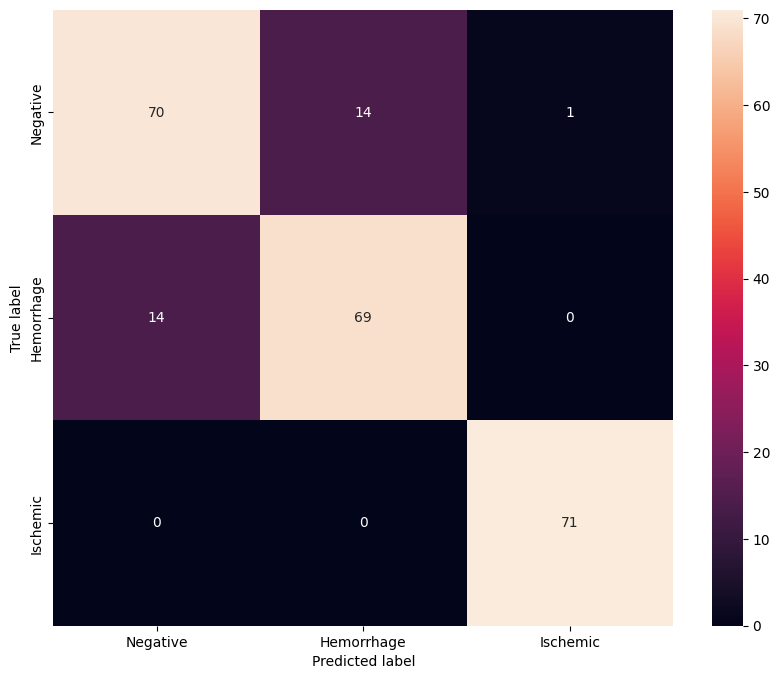

In [85]:
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['Negative', 'Hemorrhage','Ischemic']
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels = class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')




In [ ]:
#end to end training!! 
#class weight in loss function